# MAESTRO Dataset - EDA

In [24]:
from miditoolkit import MidiFile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
from miditok import REMI
from collections import defaultdict
from itertools import chain

In [ ]:
midi_paths = list(Path("maestro-v3.0.0-midi").rglob("*.midi"))

Total MIDI files: 1276
Total duration: 198.65 hours
Average duration per file: 9.34 minutes


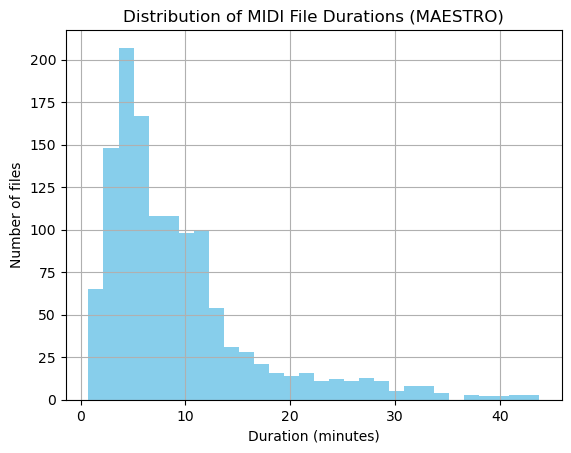

In [6]:
def get_midi_duration_seconds(midi: MidiFile):
    if len(midi.tempo_changes) == 0 or len(midi.instruments) == 0:
        return 0
    end_tick = max((note.end for inst in midi.instruments for note in inst.notes), default=0)
    tempo_bpm = midi.tempo_changes[0].tempo  
    ticks_per_beat = midi.ticks_per_beat

    seconds_per_tick = 60 / tempo_bpm / ticks_per_beat
    duration_seconds = end_tick * seconds_per_tick
    return duration_seconds
durations = []

for path in midi_paths:
    try:
        midi = MidiFile(str(path))
        dur = get_midi_duration_seconds(midi)
        if dur > 0:
            durations.append(dur)
    except Exception as e:
        print(f"Failed to read {path.name}: {e}")
print(f"Total MIDI files: {len(durations)}")
print(f"Total duration: {sum(durations)/3600:.2f} hours")
print(f"Average duration per file: {np.mean(durations)/60:.2f} minutes")

plt.hist(np.array(durations)/60, bins=30, color='skyblue')
plt.title("Distribution of MIDI File Durations (MAESTRO)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of files")
plt.grid(True)
plt.show()


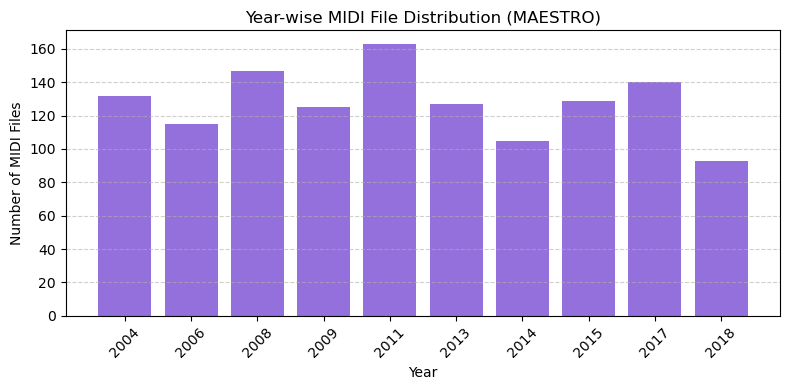

In [8]:
years = [p.parts[-2] for p in midi_paths if p.parts[-2].isdigit()]
year_counts = Counter(years)
sorted_years = sorted(year_counts)
counts = [year_counts[y] for y in sorted_years]

plt.figure(figsize=(8, 4))
plt.bar(sorted_years, counts, color='mediumpurple')
plt.title("Year-wise MIDI File Distribution (MAESTRO)")
plt.xlabel("Year")
plt.ylabel("Number of MIDI Files")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

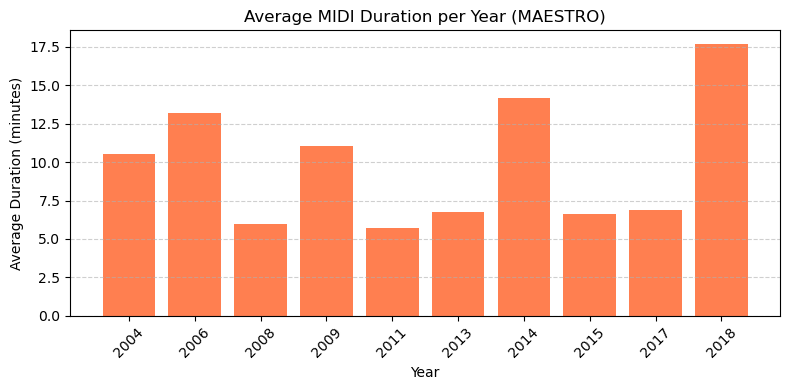

In [12]:
def get_midi_duration_seconds(midi: MidiFile):
    if len(midi.tempo_changes) == 0 or len(midi.instruments) == 0:
        return 0
    end_tick = max((note.end for inst in midi.instruments for note in inst.notes), default=0)
    tempo_bpm = midi.tempo_changes[0].tempo
    ticks_per_beat = midi.ticks_per_beat
    seconds_per_tick = 60 / tempo_bpm / ticks_per_beat
    return end_tick * seconds_per_tick

midi_root = Path("maestro-v3.0.0-midi")
midi_files = list(midi_root.rglob("*.midi"))

durations_by_year = defaultdict(list)

for midi_path in midi_files:
    year = midi_path.parts[-2] 
    try:
        midi = MidiFile(midi_path)
        dur_sec = get_midi_duration_seconds(midi)
        if dur_sec > 0:
            durations_by_year[year].append(dur_sec)
    except Exception as e:
        print(f"Error reading {midi_path.name}: {e}")

years = sorted(durations_by_year.keys())
avg_durations = [np.mean(durations_by_year[yr]) / 60 for yr in years]  

plt.figure(figsize=(8, 4))
plt.bar(years, avg_durations, color="coral")
plt.title("Average MIDI Duration per Year (MAESTRO)")
plt.xlabel("Year")
plt.ylabel("Average Duration (minutes)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

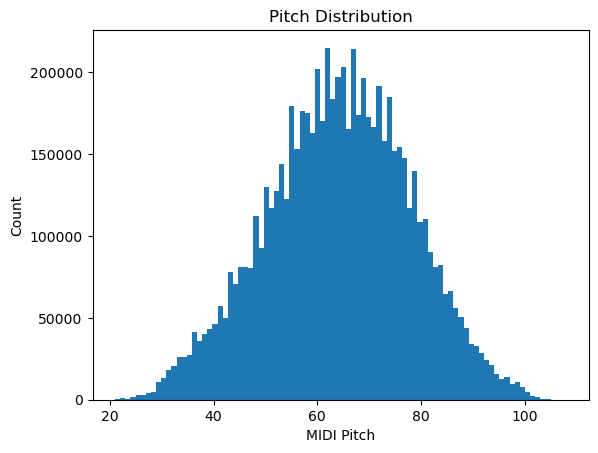

In [9]:
all_pitches = []
all_velocities = []
all_durations = []

for path in midi_paths:
    midi = MidiFile(str(path))
    for note in midi.instruments[0].notes:
        all_pitches.append(note.pitch)
        all_velocities.append(note.velocity)
        all_durations.append(note.end - note.start)

# Plot pitch histogram
plt.hist(all_pitches, bins=88, range=(21, 108))
plt.title("Pitch Distribution")
plt.xlabel("MIDI Pitch")
plt.ylabel("Count")
plt.show()


Found 1276 token files
Processed 1276 files successfully, failed 0 files


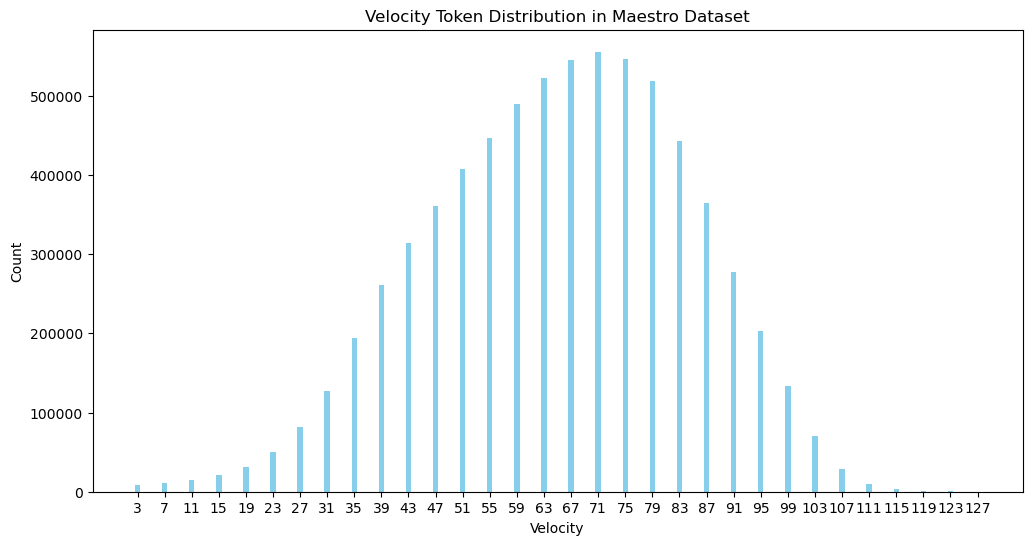

In [33]:
tokenizer = REMI()
def get_all_token_files(token_dir):
    return list(Path(token_dir).rglob("*.json"))

def extract_velocities_from_tokens(tokenizer, token_ids):
    id2token = {v: k for k, v in tokenizer.vocab.items()}
    velocities = []
    for tid in token_ids:
        token_str = id2token.get(tid, None)
        if token_str and token_str.startswith("Velocity_"):
            try:
                velocity = int(token_str.split("_")[1])
                velocities.append(velocity)
            except ValueError:
                pass
    return velocities

def aggregate_velocity_distribution(token_dir, tokenizer):
    token_files = get_all_token_files(token_dir)
    print(f"Found {len(token_files)} token files")

    all_velocities = []
    failed_files = []

    for file in token_files:
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                token_ids = data.get("ids", [])

                # Flatten nested lists if any
                if any(isinstance(i, list) for i in token_ids):
                    token_ids = [item for sublist in token_ids for item in sublist]

                velocities = extract_velocities_from_tokens(tokenizer, token_ids)
                all_velocities.extend(velocities)

        except Exception as e:
            print(f"Error decoding {file}: {e}")
            failed_files.append(file)

    print(f"Processed {len(token_files) - len(failed_files)} files successfully, failed {len(failed_files)} files")

    velocity_counts = Counter(all_velocities)
    return velocity_counts

def plot_velocity_distribution(velocity_counts):
    velocities = sorted(velocity_counts.keys())
    counts = [velocity_counts[v] for v in velocities]

    plt.figure(figsize=(12, 6))
    plt.bar(velocities, counts, color='skyblue')
    plt.xlabel('Velocity')
    plt.ylabel('Count')
    plt.title('Velocity Token Distribution in Maestro Dataset')
    plt.xticks(velocities)
    plt.show()


# Usage example:
token_dir = "maestro_tokens"  # replace with your actual path
velocity_counts = aggregate_velocity_distribution(token_dir, tokenizer)
plot_velocity_distribution(velocity_counts)


In [ ]:
tempos = []
time_sigs = []

for path in midi_paths:
    midi = MidiFile(str(path))
    tempos += [t.tempo for t in midi.tempo_changes]
    time_sigs += [(ts.numerator, ts.denominator) for ts in midi.time_signature_changes]

print("Top Tempos:", Counter(tempos).most_common(1))
print("Time Signature Counts:", Counter(time_sigs))


Top Tempos: [(120.0, 1276)]
Time Signature Counts: Counter({(4, 4): 1280})


In [ ]:
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

Tokenizer vocab size: 282


In [32]:
id2token = {v: k for k, v in tokenizer.vocab.items()}
id2token

{0: 'PAD_None',
 1: 'BOS_None',
 2: 'EOS_None',
 3: 'MASK_None',
 4: 'Bar_None',
 5: 'Pitch_21',
 6: 'Pitch_22',
 7: 'Pitch_23',
 8: 'Pitch_24',
 9: 'Pitch_25',
 10: 'Pitch_26',
 11: 'Pitch_27',
 12: 'Pitch_28',
 13: 'Pitch_29',
 14: 'Pitch_30',
 15: 'Pitch_31',
 16: 'Pitch_32',
 17: 'Pitch_33',
 18: 'Pitch_34',
 19: 'Pitch_35',
 20: 'Pitch_36',
 21: 'Pitch_37',
 22: 'Pitch_38',
 23: 'Pitch_39',
 24: 'Pitch_40',
 25: 'Pitch_41',
 26: 'Pitch_42',
 27: 'Pitch_43',
 28: 'Pitch_44',
 29: 'Pitch_45',
 30: 'Pitch_46',
 31: 'Pitch_47',
 32: 'Pitch_48',
 33: 'Pitch_49',
 34: 'Pitch_50',
 35: 'Pitch_51',
 36: 'Pitch_52',
 37: 'Pitch_53',
 38: 'Pitch_54',
 39: 'Pitch_55',
 40: 'Pitch_56',
 41: 'Pitch_57',
 42: 'Pitch_58',
 43: 'Pitch_59',
 44: 'Pitch_60',
 45: 'Pitch_61',
 46: 'Pitch_62',
 47: 'Pitch_63',
 48: 'Pitch_64',
 49: 'Pitch_65',
 50: 'Pitch_66',
 51: 'Pitch_67',
 52: 'Pitch_68',
 53: 'Pitch_69',
 54: 'Pitch_70',
 55: 'Pitch_71',
 56: 'Pitch_72',
 57: 'Pitch_73',
 58: 'Pitch_74',
 59: '

# Baseline - Markov Chain Model

In [7]:
#!pip install miditok transformers datasets miditoolkit midi2audio fluidsynth torch --quiet
#!sudo apt install -y fluidsynth 
#!pip install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --quiet

^C


In [103]:
from miditok import REMI, TokenizerConfig
from miditoolkit import MidiFile
from pathlib import Path
from datasets import load_dataset, Dataset
#from transformers import PreTrainedTokenizerFast
from pathlib import Path
from itertools import chain
from pathlib import Path
import json
import torch
from collections import Counter
import numpy as np
from scipy.stats import entropy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import default_collate
from midi2audio import FluidSynth # Import library
from IPython.display import Audio, display
#from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling, TrainerCallback, pipeline

In [105]:
dataset_dir = "maestro-v3.0.0-midi/maestro-v3.0.0/"
output_dir = "music_Markov_Chain_checkpoints_new"

import os
os.makedirs(output_dir, exist_ok=True)

In [107]:
# Configure tokenizer
config = TokenizerConfig(
    use_chords=True,
    use_programs=False,
    num_velocities=32,
    tempo=True,
    time_signature=True,
    rest=True
)
tokenizer = REMI(config)

# Create token directory
token_dir = Path("maestro_tokens")
token_dir.mkdir(exist_ok=True)

# Convert all MIDI files
midi_files = list(Path(dataset_dir).rglob("*.midi"))
print(f"Found {len(midi_files)} MIDI files.")
tokenizer.tokenize_midi_dataset(midi_files, token_dir)

Found 1276 MIDI files.


C:\Users\avant\AppData\Local\Temp\ipykernel_35148\1869637921.py:19: UserWarning: miditok: The `tokenize_midi_dataset` method had been renamed `tokenize_dataset`. It is now depreciated and will be removed in future updates.
  tokenizer.tokenize_midi_dataset(midi_files, token_dir)
Tokenizing music files (Downloads/maestro_tokens): 100%|██████████| 1276/1276 [08:11<00:00,  2.60it/s] 


In [108]:
def load_tokens(token_files, tokenizer, max_len=512, stride=256):
    samples = []
    pad_id = tokenizer.vocab["PAD_None"]

    for file in token_files:
        with open(file) as f:
            data = json.load(f)
            tokens_nested = data.get("ids", [])

            if any(isinstance(i, list) for i in tokens_nested):
                tokens = list(chain.from_iterable(tokens_nested))
            else:
                tokens = tokens_nested

            # Sliding window
            for i in range(0, len(tokens) - max_len + 1, stride):
                chunk = tokens[i: i + max_len]
                samples.append({
                    "input_ids": chunk,
                    "labels": chunk.copy()
                })

            # Optional: pad the final shorter segment
            if len(tokens) % stride != 0 and len(tokens) > stride:
                chunk = tokens[-max_len:]
                if len(chunk) < max_len:
                    chunk += [pad_id] * (max_len - len(chunk))
                samples.append({
                    "input_ids": chunk,
                    "labels": chunk.copy()
                })

    return samples

In [109]:
def get_all_token_files(token_dir):
    return list(Path(token_dir).rglob("*.json"))

token_files = get_all_token_files(token_dir)
print(f"Found {len(token_files)} token json files")

Found 1276 token json files


In [110]:
token_data = load_tokens(token_files, tokenizer)
dataset = Dataset.from_list(token_data)
# print(dataset)

In [111]:
dataset = list(dataset['input_ids'])

## Model definition and Training

In [148]:
import random
from collections import defaultdict, Counter
import math
import numpy as np
from scipy.stats import entropy

class SimpleMarkovChain:
    def __init__(self, order=4):
        self.order = order
        self.chain = defaultdict(list)
        self.bos_token = None
        self.eos_token = None
        self.vocab = set()

    def train(self, sequences):
        """Train on list of token sequences"""
        for seq in sequences:
            self.vocab.update(seq)
            for i in range(len(seq) - self.order):
                key = tuple(seq[i:i + self.order])
                next_token = seq[i + self.order]
                self.chain[key].append(next_token)

    def generate(self, max_length=512, start_tokens=None):
        """Generate sequence"""
        if start_tokens and len(start_tokens) >= self.order:
            current = tuple(start_tokens[-self.order:])
            result = list(start_tokens)
        else:
            if not self.chain:
                return []
            current = random.choice(list(self.chain.keys()))
            result = list(current)

        for _ in range(max_length - len(result)):
            if current in self.chain and self.chain[current]:
                next_token = random.choice(self.chain[current])
                result.append(next_token)
                current = tuple(result[-self.order:])

                if next_token == self.eos_token:
                    break
            else:
                break

        return result

    def evaluate(self, test_sequences, metric='perplexity'):
        """Evaluate the model on test sequences"""
        if metric == 'perplexity':
            return self._calculate_perplexity(test_sequences)
        elif metric == 'accuracy':
            return self._calculate_accuracy(test_sequences)
        elif metric == 'coverage':
            return self._calculate_coverage(test_sequences)
        elif metric == 'all':
            return {
                'perplexity': self._calculate_perplexity(test_sequences),
                'accuracy': self._calculate_accuracy(test_sequences),
                'coverage': self._calculate_coverage(test_sequences),
                'ngram_diversity': self._calculate_ngram_diversity(test_sequences, n=4),
                'pitch_histogram_entropy': self._calculate_pitch_histogram_entropy(test_sequences)
            }

    def _calculate_perplexity(self, test_sequences):
        total_log_prob = 0
        total_tokens = 0

        for seq in test_sequences:
            for i in range(len(seq) - self.order):
                key = tuple(seq[i:i + self.order])
                next_token = seq[i + self.order]

                if key in self.chain:
                    token_counts = Counter(self.chain[key])
                    total_next = len(self.chain[key])
                    prob = token_counts[next_token] / total_next if next_token in token_counts else 1e-10
                else:
                    prob = 1e-10

                total_log_prob += math.log(prob)
                total_tokens += 1

        if total_tokens == 0:
            return {'perplexity': float('inf'), 'avg_log_prob': 0, 'total_tokens': 0}

        avg_log_prob = total_log_prob / total_tokens
        perplexity = math.exp(-avg_log_prob)

        return {
            'perplexity': perplexity,
            'avg_log_prob': avg_log_prob,
            'total_tokens': total_tokens
        }

    def _calculate_accuracy(self, test_sequences):
        correct = 0
        total = 0

        for seq in test_sequences:
            for i in range(len(seq) - self.order):
                key = tuple(seq[i:i + self.order])
                actual_next = seq[i + self.order]

                if key in self.chain and self.chain[key]:
                    token_counts = Counter(self.chain[key])
                    predicted_next = token_counts.most_common(1)[0][0]

                    if predicted_next == actual_next:
                        correct += 1

                total += 1

        accuracy = correct / total if total > 0 else 0

        return {
            'accuracy': accuracy,
            'correct_predictions': correct,
            'total_predictions': total
        }

    def _calculate_ngram_diversity(self, test_sequences, n=4):
        """Calculate n-gram diversity across all test sequences"""
        all_ngrams = []
        
        for sequence in test_sequences:
            if len(sequence) >= n:
                ngrams = [tuple(sequence[i:i + n]) for i in range(len(sequence) - n + 1)]
                all_ngrams.extend(ngrams)
        
        if not all_ngrams:
            return 0.0
            
        unique_ngrams = set(all_ngrams)
        diversity = len(unique_ngrams) / len(all_ngrams)
        
        return {
            'diversity': diversity,
            'unique_ngrams': len(unique_ngrams),
            'total_ngrams': len(all_ngrams)
        }

    def _calculate_pitch_histogram_entropy(self, test_sequences):
        """Calculate entropy of pitch distribution across all test sequences"""
        pitch_values = []
        
        for sequence in test_sequences:
            for token in sequence:
                # Handle both string tokens and numeric tokens
                if isinstance(token, str) and token.startswith("Pitch_"):
                    try:
                        pitch_val = int(token.split("_")[1])
                        pitch_values.append(pitch_val)
                    except (IndexError, ValueError):
                        continue
                elif isinstance(token, (int, float)):
                    # If tokens are numeric and represent pitches directly
                    pitch_values.append(token)

        if not pitch_values:
            return {
                'entropy': 0.0,
                'unique_pitches': 0,
                'total_pitches': 0
            }

        pitch_counts = Counter(pitch_values)
        probs = np.array(list(pitch_counts.values())) / len(pitch_values)
        pitch_entropy = entropy(probs, base=2)
        
        return {
            'entropy': pitch_entropy,
            'unique_pitches': len(pitch_counts),
            'total_pitches': len(pitch_values)
        }

    def _calculate_coverage(self, test_sequences):
        test_vocab = set()
        test_states = set()

        for seq in test_sequences:
            test_vocab.update(seq)
            for i in range(len(seq) - self.order):
                test_states.add(tuple(seq[i:i + self.order]))

        vocab_coverage = len(self.vocab.intersection(test_vocab)) / len(test_vocab) if test_vocab else 0
        state_coverage = len(set(self.chain.keys()).intersection(test_states)) / len(test_states) if test_states else 0

        return {
            'vocab_coverage': vocab_coverage,
            'state_coverage': state_coverage,
            'known_vocab': len(self.vocab),
            'test_vocab': len(test_vocab)
        }

   
print("=== MARKOV CHAIN MUSIC GENERATOR ===\n")

# 1. Initialize model
model = SimpleMarkovChain(order=6)

# 2. Train the model
print("1. TRAINING...")
print(f"Training on {len(dataset)} sequences")
model.train(dataset)
print("Training complete!\n")

# 3. Show model statistics
print("2. MODEL STATISTICS:")
vocab_size = len(model.vocab)
unique_states = len(model.chain)
total_transitions = sum(len(transitions) for transitions in model.chain.values())

print(f"- Vocabulary size: {vocab_size}")
print(f"- Unique states: {unique_states}")
print(f"- Total transitions: {total_transitions}")
print(f"- Vocabulary: {sorted(list(model.vocab))}")
print()

=== MARKOV CHAIN MUSIC GENERATOR ===

1. TRAINING...
Training on 99409 sequences
Training complete!

2. MODEL STATISTICS:
- Vocabulary size: 229
- Unique states: 19069783
- Total transitions: 50300954
- Vocabulary: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 1

In [149]:
# 4. Generate samples
print("3. GENERATION:")
samples = []
for i in range(3):
    sample = model.generate(max_length=600)
    samples.append(sample)
    print(f"Sample {i+1}: {sample}")
print()

# 5. Evaluation
results = model.evaluate(samples, metric='all')


# 6. Detailed evaluation breakdown
print("5. DETAILED EVALUATION:")
print(f"- Correct predictions: {results['accuracy']['correct_predictions']}/{results['accuracy']['total_predictions']}")


3. GENERATION:
Sample 1: [105, 129, 49, 108, 125, 216, 46, 109, 126, 218, 72, 116, 128, 41, 111, 127, 60, 113, 128, 220, 38, 111, 126, 4, 190, 34, 114, 125, 22, 113, 125, 55, 114, 126, 193, 63, 110, 126, 39, 109, 125, 41, 108, 125, 67, 110, 125, 204, 65, 108, 125, 205, 36, 107, 125, 33, 105, 125, 195, 65, 112, 125, 41, 111, 125, 217, 26, 119, 125, 218, 14, 115, 125, 43, 113, 127, 4, 189, 25, 118, 125, 13, 112, 126, 12, 114, 125, 24, 108, 125, 4, 189, 22, 107, 125, 190, 34, 110, 125, 191, 58, 112, 125, 46, 109, 125, 52, 114, 125, 64, 111, 125, 54, 106, 125, 212, 73, 112, 126, 213, 72, 112, 126, 78, 112, 125, 215, 75, 107, 125, 76, 104, 125, 216, 32, 106, 128, 217, 78, 110, 125, 218, 75, 110, 125, 220, 51, 107, 125, 4, 191, 39, 107, 125, 194, 34, 107, 125, 196, 47, 112, 125, 44, 109, 125, 208, 40, 111, 125, 72, 114, 126, 215, 33, 113, 126, 65, 119, 125, 53, 117, 125, 74, 116, 125, 50, 114, 125, 38, 113, 125, 65, 110, 125, 41, 112, 125, 56, 114, 125, 44, 114, 125, 46, 105, 125, 4, 189, 46

In [150]:
print(results)

{'perplexity': {'perplexity': 1.6340750025181017, 'avg_log_prob': -0.49107689655825326, 'total_tokens': 1782}, 'accuracy': {'accuracy': 0.7794612794612794, 'correct_predictions': 1389, 'total_predictions': 1782}, 'coverage': {'vocab_coverage': 1.0, 'state_coverage': 1.0, 'known_vocab': 229, 'test_vocab': 145}, 'ngram_diversity': {'diversity': 0.9927414852037968, 'unique_ngrams': 1778, 'total_ngrams': 1791}, 'pitch_histogram_entropy': {'entropy': 6.119825838174725, 'unique_pitches': 145, 'total_pitches': 1800}}


In [154]:
from midi2audio import FluidSynth # Import library
from IPython.display import Audio, display
fs = FluidSynth("FluidR3Mono_GM.sf3") # Initialize FluidSynth

output_score = tokenizer.tokens_to_midi([samples[1]])
output_score.dump_midi(f"gen.mid")

C:\Users\avant\AppData\Local\Temp\ipykernel_35148\4090432755.py:5: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  output_score = tokenizer.tokens_to_midi([samples[1]])


# TASK 1: Improvement with GPT-2

## Download and import Dependencies 

In [13]:
!pip install miditok transformers datasets miditoolkit midi2audio fluidsynth torch --quiet
!sudo apt install -y fluidsynth 
!pip install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --quiet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.


In [ ]:
from miditok import REMI, TokenizerConfig
from miditoolkit import MidiFile
from pathlib import Path
from datasets import load_dataset, Dataset
from transformers import PreTrainedTokenizerFast
from pathlib import Path
from itertools import chain
from pathlib import Path
import json
import torch
from collections import Counter
import numpy as np
from scipy.stats import entropy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import default_collate
from midi2audio import FluidSynth
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling, TrainerCallback, pipeline
import os

## Data Preprocessing

In [8]:
dataset_dir = "/kaggle/input/maestro/maestro-v3.0.0"
output_dir = "music_transformer_checkpoints_new"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
config = TokenizerConfig(
    use_chords=True,
    use_programs=False,
    num_velocities=32,
    tempo=True,
    time_signature=True,
    rest=True
)

tokenizer = REMI(config)

token_dir = Path("maestro_tokens")
token_dir.mkdir(exist_ok=True)

midi_files = list(Path(dataset_dir).rglob("*.midi"))
print(f"Found {len(midi_files)} MIDI files.")
tokenizer.tokenize_midi_dataset(midi_files, token_dir)

Found 1276 MIDI files.


/tmp/ipykernel_35/2702901965.py:20: UserWarning: miditok: The `tokenize_midi_dataset` method had been renamed `tokenize_dataset`. It is now depreciated and will be removed in future updates.
  tokenizer.tokenize_midi_dataset(midi_files, token_dir)
Tokenizing music files (working/maestro_tokens): 100%|██████████| 1276/1276 [03:49<00:00,  5.56it/s]


In [ ]:
def load_tokens(token_files, tokenizer, max_len=512, stride=256):
    samples = []
    pad_id = tokenizer.vocab["PAD_None"]

    for file in token_files:
        with open(file) as f:
            data = json.load(f)
            tokens_nested = data.get("ids", [])

            if any(isinstance(i, list) for i in tokens_nested):
                tokens = list(chain.from_iterable(tokens_nested))
            else:
                tokens = tokens_nested

            for i in range(0, len(tokens) - max_len + 1, stride):
                chunk = tokens[i: i + max_len]
                samples.append({
                    "input_ids": chunk,
                    "labels": chunk.copy()
                })

            if len(tokens) % stride != 0 and len(tokens) > stride:
                chunk = tokens[-max_len:]
                if len(chunk) < max_len:
                    chunk += [pad_id] * (max_len - len(chunk))
                samples.append({
                    "input_ids": chunk,
                    "labels": chunk.copy()
                })
    return samples

In [18]:
def get_all_token_files(token_dir):
    return list(Path(token_dir).rglob("*.json"))

token_files = get_all_token_files(token_dir)
print(f"Found {len(token_files)} token json files")

Found 1276 token json files


In [19]:
token_data = load_tokens(token_files, tokenizer)
dataset = Dataset.from_list(token_data)
# print(dataset)

## Model Training

In [ ]:
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=512,
    n_ctx=512,
    n_embd=512,
    n_layer=6,
    n_head=8,
    bos_token_id=tokenizer.vocab["BOS_None"],
    eos_token_id=tokenizer.vocab["EOS_None"]
)

model = GPT2LMHeadModel(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(296, 512)
    (wpe): Embedding(512, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=1536, nx=512)
          (c_proj): Conv1D(nf=512, nx=512)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=2048, nx=512)
          (c_proj): Conv1D(nf=512, nx=2048)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=512, out_features=296, bias=False)
)

In [21]:
def custom_data_collator(batch):
    input_ids = [torch.tensor(x['input_ids']) for x in batch]
    labels = [torch.tensor(x['labels']) for x in batch]

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # -100 = ignored in loss

    return {
        'input_ids': input_ids,
        'labels': labels
    }

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir='./logs',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    logging_steps=1000,
    prediction_loss_only=False,
    dataloader_num_workers=4,
    remove_unused_columns=False,
    report_to="none"
)

class ProgressCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            print(f"Step {state.global_step}/{state.max_steps}, Loss: {logs['loss']:.4f}")

data_collator = DataCollatorForLanguageModeling(tokenizer=None, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=None,
    data_collator=custom_data_collator,
    callbacks=[ProgressCallback()]
)
print("Training started")
trainer.train()
print("training completed")

/tmp/ipykernel_35/3184612154.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training started


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1000,1.570500
2000,1.388300
3000,1.307900
4000,1.276500
5000,1.252300
6000,1.240300
7000,1.231700
8000,1.224800
9000,1.219400
10000,1.207500


Step 1000/74559, Loss: 1.5705
Step 2000/74559, Loss: 1.3883
Step 3000/74559, Loss: 1.3079
Step 4000/74559, Loss: 1.2765
Step 5000/74559, Loss: 1.2523
Step 6000/74559, Loss: 1.2403
Step 7000/74559, Loss: 1.2317
Step 8000/74559, Loss: 1.2248
Step 9000/74559, Loss: 1.2194
Step 10000/74559, Loss: 1.2075
Step 11000/74559, Loss: 1.2060
Step 12000/74559, Loss: 1.2048
Step 13000/74559, Loss: 1.1993
Step 14000/74559, Loss: 1.1867
Step 15000/74559, Loss: 1.1851
Step 16000/74559, Loss: 1.1872
Step 17000/74559, Loss: 1.1803
Step 18000/74559, Loss: 1.1741
Step 19000/74559, Loss: 1.1673
Step 20000/74559, Loss: 1.1686
Step 21000/74559, Loss: 1.1623
Step 22000/74559, Loss: 1.1507
Step 23000/74559, Loss: 1.1417
Step 24000/74559, Loss: 1.1393
Step 25000/74559, Loss: 1.1312
Step 26000/74559, Loss: 1.1297
Step 27000/74559, Loss: 1.1236
Step 28000/74559, Loss: 1.1156
Step 29000/74559, Loss: 1.1145
Step 30000/74559, Loss: 1.1146
Step 31000/74559, Loss: 1.1053
Step 32000/74559, Loss: 1.1050
Step 33000/74559,

## Training Statistics

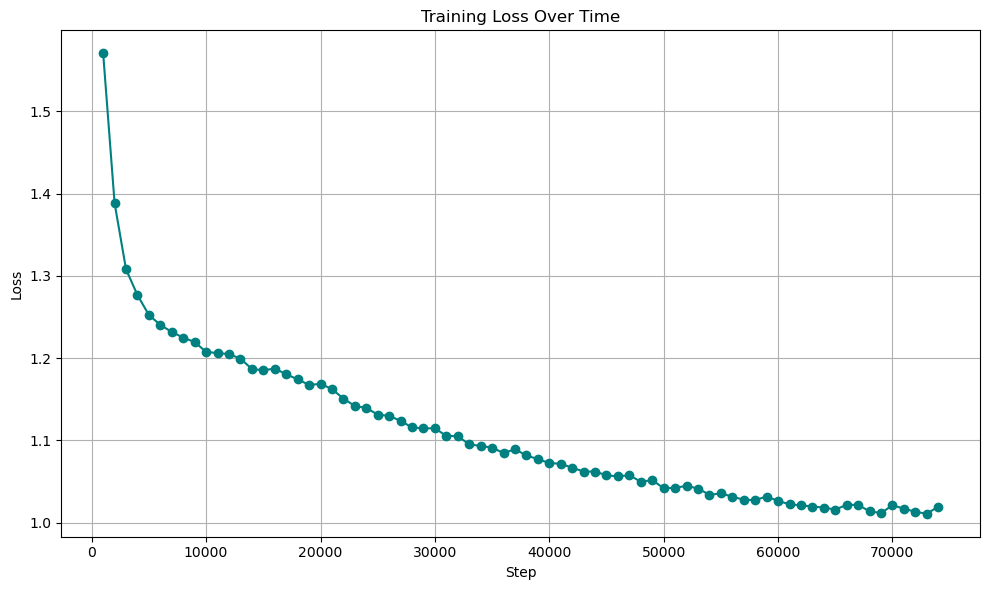

In [ ]:
steps = [
    1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,
    11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000,
    21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000,
    31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000,
    41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000,
    51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000,
    61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000,
    71000, 72000, 73000, 74000
]

losses = [
    1.5705, 1.3883, 1.3079, 1.2765, 1.2523, 1.2403, 1.2317, 1.2248, 1.2194, 1.2075,
    1.2060, 1.2048, 1.1993, 1.1867, 1.1851, 1.1872, 1.1803, 1.1741, 1.1673, 1.1686,
    1.1623, 1.1507, 1.1417, 1.1393, 1.1312, 1.1297, 1.1236, 1.1156, 1.1145, 1.1146,
    1.1053, 1.1050, 1.0950, 1.0931, 1.0910, 1.0845, 1.0891, 1.0815, 1.0771, 1.0723,
    1.0714, 1.0666, 1.0620, 1.0619, 1.0575, 1.0560, 1.0576, 1.0495, 1.0516, 1.0416,
    1.0422, 1.0446, 1.0413, 1.0337, 1.0353, 1.0315, 1.0276, 1.0273, 1.0316, 1.0263,
    1.0221, 1.0209, 1.0194, 1.0182, 1.0157, 1.0215, 1.0214, 1.0136, 1.0115, 1.0210,
    1.0168, 1.0130, 1.0107, 1.0193
]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', linestyle='-', color='teal')
plt.title('Training Loss Over Time')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

## Music Generation and Evaluation

In [ ]:
model.eval()
input_ids = torch.tensor([[tokenizer["PAD_None"]]]).to(model.device)

sample_output = model.generate(
    input_ids,
    max_length=512,
    temperature=1.0,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    num_return_sequences=1
)

generated_tokens = sample_output[0].tolist()
print("Generated tokens:", generated_tokens)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated tokens: [0, 42, 106, 129, 4, 193, 35, 103, 130, 197, 33, 105, 130, 201, 43, 106, 130, 206, 30, 104, 133, 212, 47, 107, 126, 215, 42, 105, 125, 218, 47, 106, 125, 4, 190, 54, 107, 126, 42, 103, 125, 192, 59, 110, 125, 195, 66, 111, 129, 42, 106, 129, 198, 52, 106, 125, 42, 102, 125, 199, 66, 108, 127, 203, 71, 110, 130, 42, 104, 129, 206, 54, 105, 127, 210, 71, 109, 128, 42, 104, 126, 214, 54, 108, 127, 218, 59, 110, 128, 219, 47, 105, 126, 42, 106, 126, 4, 190, 54, 110, 125, 192, 71, 113, 126, 194, 42, 104, 130, 195, 54, 105, 127, 196, 66, 111, 126, 199, 71, 112, 129, 42, 103, 126, 202, 54, 104, 126, 205, 66, 110, 126, 42, 102, 126, 207, 78, 113, 129, 208, 42, 105, 128, 212, 54, 104, 126, 215, 66, 111, 126, 40, 104, 127, 217, 64, 111, 125, 219, 42, 106, 125, 54, 108, 125, 220, 73, 113, 129, 4, 191, 42, 106, 125, 58, 108, 125, 194, 52, 106, 126, 196, 66, 111, 129, 42, 103, 125, 199, 47, 106, 125, 42, 105, 125, 62, 112, 127, 202, 50, 107, 125, 204, 38, 106, 126, 59, 109, 128, 2

In [27]:
checkpoint_dirs = [d for d in os.listdir(output_dir) if d.startswith("checkpoint")]
checkpoint_dirs.sort(key=lambda x: int(x.split("-")[-1]))  
latest_checkpoint = os.path.join(output_dir, checkpoint_dirs[-1])
model_loaded = GPT2LMHeadModel.from_pretrained(latest_checkpoint, config=config)
print(f"Loaded model from {latest_checkpoint}")

Loaded model from music_transformer_checkpoints_new/checkpoint-74559


In [ ]:
def ngram_diversity(sequence, n=4):
    ngrams = [tuple(sequence[i:i+n]) for i in range(len(sequence)-n+1)]
    unique_ngrams = set(ngrams)
    return len(unique_ngrams) / len(ngrams) if ngrams else 0.0

def pitch_histogram_entropy(token_ids, tokenizer):
    id_to_token = {v: k for k, v in tokenizer.vocab.items()}

    pitch_values = []
    for tid in token_ids:
        token_str = id_to_token.get(tid, "")
        if token_str.startswith("Pitch_"):
            try:
                pitch_val = int(token_str.split("_")[1])
                pitch_values.append(pitch_val)
            except:
                continue

    if not pitch_values:
        return 0.0

    pitch_counts = Counter(pitch_values)
    probs = np.array(list(pitch_counts.values())) / sum(pitch_counts.values())
    return entropy(probs, base=2)  

def calculate_perplexity(model, sequence, max_length=512, stride=512):
    model.eval()
    losses = []
    sequence = torch.tensor(sequence, dtype=torch.long)

    for i in range(0, len(sequence) - 1, stride):
        input_chunk = sequence[i:i + max_length]
        target_chunk = input_chunk.clone()

        if input_chunk.size(0) < 2:
            continue  

        input_chunk = input_chunk.unsqueeze(0).to(model.device)
        target_chunk = target_chunk.unsqueeze(0).to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_chunk, labels=target_chunk)
            loss = outputs.loss
            losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    perplexity = torch.exp(torch.tensor(avg_loss))
    return avg_loss, perplexity.item()
    
def save_music(tokenizer, tokens, filename):
    fs = FluidSynth("FluidR3Mono_GM.sf3") 
    output_score = tokenizer.tokens_to_midi([tokens])
    output_score.dump_midi(filename+".mid")
    fs.midi_to_audio(filename+".mid", filename+".wav")

def compute_remi_vocab_coverage_from_ids(all_generated_token_ids, remi_tokenizer):
    vocab_size = len(remi_tokenizer.vocab)
    used_token_ids = set(all_generated_token_ids)
    valid_token_ids = {tid for tid in used_token_ids if 0 <= tid < vocab_size}
    coverage = (len(valid_token_ids) / vocab_size) * 100
    return coverage


def evaluate(tokens, tokenizer, model):
    print("--------------------------------------------------")
    print("tokens generated: ",len(tokens))
    print("ngram diversity: ", ngram_diversity(tokens))
    print("pitch histogram entropy: ",pitch_histogram_entropy(tokens, tokenizer))
    print("Perplexity:", calculate_perplexity(model, tokens))
    print("Vocab coverage: ", compute_remi_vocab_coverage_from_ids(tokens, tokenizer))
    print("--------------------------------------------------")

## Short sequence

In [ ]:
evaluate(generated_tokens, tokenizer, model_loaded)

--------------------------------------------------
tokens generated:  512
ngram diversity:  0.9941060903732809
pitch histogram entropy:  3.8783117402055334
Perplexity: (1.8281729221343994, 6.222507476806641)
Vocab coverage:  28.37837837837838
--------------------------------------------------


## Longer Sequences

In [67]:
max_context = 5  
desired_length = 6000
generated = input_ids  

all_generated_tokens = generated.tolist()[0]  

for _ in range(desired_length // 512):
    output = model_loaded.generate(
        generated,
        max_length= 512,  
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        do_sample=True,
        num_return_sequences=1
    )
    new_tokens = output[0, generated.size(1):].tolist()
    all_generated_tokens.extend(new_tokens)

    next_input_tokens = output[0, -max_context:].unsqueeze(0)  

    generated = next_input_tokens.to(model_loaded.device)

print(f"Total generated tokens: {len(all_generated_tokens)}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Total generated tokens: 5582


In [100]:
save_music(tokenizer,all_generated_tokens, "long"+str(len(all_generated_tokens))+"tokens")

/tmp/ipykernel_35/1088515461.py:5: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  output_score = tokenizer.tokens_to_midi([generated_tokens])
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter 'FluidR3Mono_GM.sf3' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'long5582tokens.wav'..


In [ ]:
evaluate(all_generated_tokens, tokenizer, model_loaded)

--------------------------------------------------
tokens generated:  5582
ngram diversity:  0.9526796917010217
pitch histogram entropy:  5.56253854626898
Perplexity: (1.3550739071585916, 3.877047538757324)
Vocab coverage:  50.0
--------------------------------------------------


In [15]:
checkpoint_dirs = [d for d in os.listdir(output_dir) if d.startswith("checkpoint")]
print(checkpoint_dirs)
checkpoint_dirs.sort(key=lambda x: int(x.split("-")[-1]))  
latest_checkpoint = os.path.join(output_dir, checkpoint_dirs[-1])
model_loaded_new = GPT2LMHeadModel.from_pretrained(latest_checkpoint, config=config)
print(f"Loaded model from {latest_checkpoint}")

['checkpoint-74559']
Loaded model from music_transformer_checkpoints_new\checkpoint-74559


In [60]:
input_ids = torch.tensor([[tokenizer["PAD_None"]]]).to(model_loaded_new.device)
max_context = 1
desired_length = 6000
generated = input_ids  
all_generated_tokens = generated.tolist()[0]  

for _ in range(desired_length // 512):
    output = model_loaded_new.generate(
        generated,
        max_length= 512,  
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        do_sample=True,
        num_return_sequences=1
    )
    new_tokens = output[0, generated.size(1):].tolist()
    all_generated_tokens.extend(new_tokens)
    next_input_tokens = output[0, -max_context:].unsqueeze(0)  

    generated = next_input_tokens.to(model_loaded_new.device)

print(f"Total generated tokens: {len(all_generated_tokens)}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Total generated tokens: 5622


In [61]:
save_music(tokenizer,all_generated_tokens, "long"+str(len(all_generated_tokens))+"tokens")
evaluate(all_generated_tokens, tokenizer, model_loaded_new)

C:\Users\shrav\AppData\Local\Temp\ipykernel_58084\1980744912.py:54: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  output_score = tokenizer.tokens_to_midi([tokens])


--------------------------------------------------
tokens generated:  5622
ngram diversity:  0.9451859761523402
pitch histogram entropy:  5.328721806584134
Perplexity: (1.4341781681234187, 4.196194648742676)
Vocab coverage:  43.58108108108108
--------------------------------------------------


In [62]:
input_ids = torch.tensor([[tokenizer["PAD_None"]]]).to(model_loaded_new.device)
max_context = 2
desired_length = 5000
generated = input_ids  
all_generated_tokens = generated.tolist()[0]  

for _ in range(desired_length // 512):
    output = model_loaded_new.generate(
        generated,
        max_length= 512,  
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        do_sample=True,
        num_return_sequences=1
    )
    new_tokens = output[0, generated.size(1):].tolist()
    all_generated_tokens.extend(new_tokens)
    next_input_tokens = output[0, -max_context:].unsqueeze(0)  

    generated = next_input_tokens.to(model_loaded_new.device)

print(f"Total generated tokens: {len(all_generated_tokens)}")
save_music(tokenizer,all_generated_tokens, "long"+str(len(all_generated_tokens))+"tokens")
evaluate(all_generated_tokens, tokenizer, model_loaded_new)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Total generated tokens: 4592


C:\Users\shrav\AppData\Local\Temp\ipykernel_58084\1980744912.py:54: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  output_score = tokenizer.tokens_to_midi([tokens])


--------------------------------------------------
tokens generated:  4592
ngram diversity:  0.9760296360862933
pitch histogram entropy:  5.7162734757725415
Perplexity: (1.5098460117975872, 4.526033401489258)
Vocab coverage:  49.66216216216216
--------------------------------------------------


## Model Parameters

In [37]:
total_params = sum(p.numel() for p in model_loaded_new.parameters())
print(f"Total parameters: {total_params}")

# Trainable parameters only
trainable_params = sum(p.numel() for p in model_loaded_new.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Total parameters: 19329024
Trainable parameters: 19329024


# Nottingham Dataset - EDA

In [16]:
from miditoolkit import MidiFile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
from miditok import REMI
from collections import defaultdict
from itertools import chain

Total valid MIDI files: 3089
 Total duration: 57.84 hours
 Average duration per file: 1.12 minutes


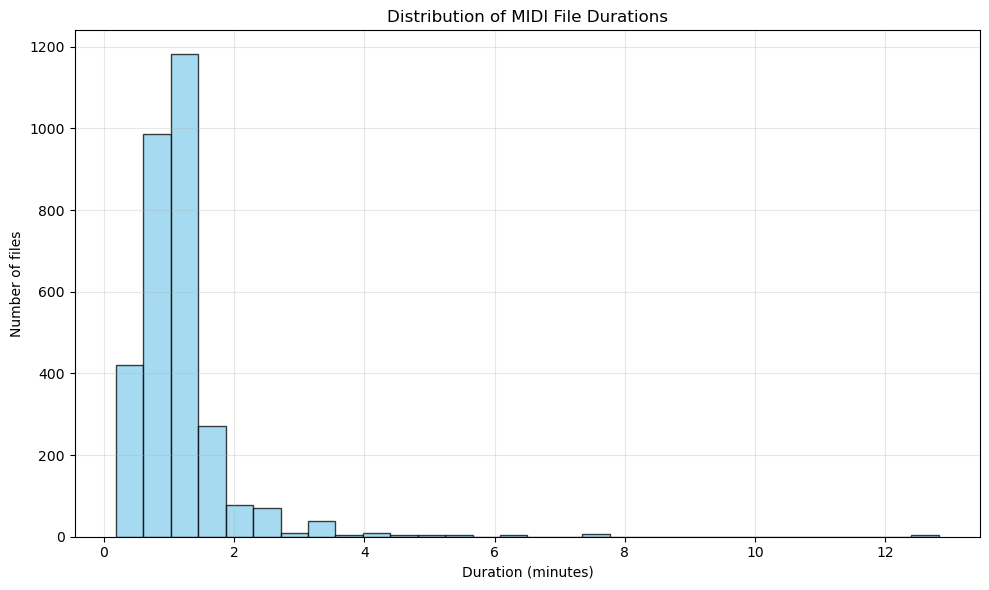

In [23]:
# Load all valid .mid files from the MIDI directory
midi_paths = [p for p in Path("MIDI").rglob("*.mid") if not p.name.startswith("._")]

def get_midi_duration_seconds(midi: MidiFile):
    """Calculate duration of a MIDI file in seconds."""
    if not midi.instruments or not midi.tempo_changes:
        return 0

    end_tick = max((note.end for inst in midi.instruments for note in inst.notes), default=0)
    tempo_bpm = midi.tempo_changes[0].tempo
    ticks_per_beat = midi.ticks_per_beat
    seconds_per_tick = 60 / tempo_bpm / ticks_per_beat
    return end_tick * seconds_per_tick

# Analyze valid MIDI files
durations = []
for path in midi_paths:
    try:
        midi = MidiFile(str(path))
        duration = get_midi_duration_seconds(midi)
        if duration > 0:
            durations.append(duration)
    except Exception as e:
        print(f"Skipped {path.name}: {e}")

# Print dataset statistics
print(f"Total valid MIDI files: {len(durations)}")
print(f" Total duration: {sum(durations)/3600:.2f} hours")
print(f" Average duration per file: {np.mean(durations)/60:.2f} minutes")

# Plot duration histogram
plt.figure(figsize=(10, 6))
plt.hist(np.array(durations) / 60, bins=30, color='skyblue', alpha=0.75, edgecolor='black')
plt.title("Distribution of MIDI File Durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of files")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


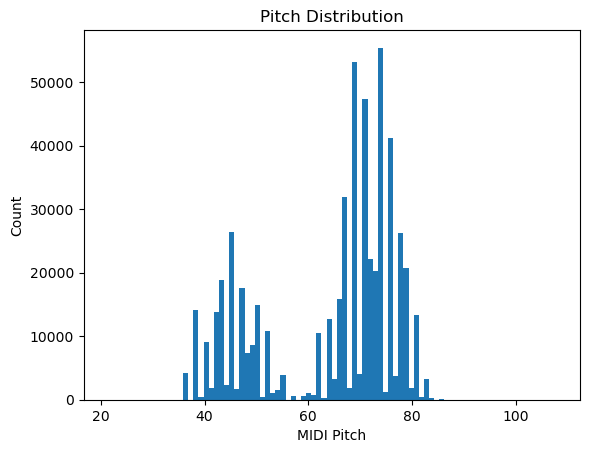

In [25]:
all_pitches = []
all_velocities = []
all_durations = []

for path in midi_paths:
    midi = MidiFile(str(path))
    for note in midi.instruments[0].notes:
        all_pitches.append(note.pitch)
        all_velocities.append(note.velocity)
        all_durations.append(note.end - note.start)

# Plot pitch histogram
plt.hist(all_pitches, bins=88, range=(21, 108))
plt.title("Pitch Distribution")
plt.xlabel("MIDI Pitch")
plt.ylabel("Count")
plt.show()


In [26]:
# Configure tokenizer
from miditok import REMI, TokenizerConfig
config = TokenizerConfig(
    use_chords=True,
    use_programs=False,
    num_velocities=32,
    tempo=True,
    time_signature=True,
    rest=True
)

tokenizer = REMI(config)

# Create token directory
token_dir = Path("mid_tokens")
token_dir.mkdir(exist_ok=True)

dataset_dir = "MIDI"
# Convert all MIDI files
midi_files = list(Path(dataset_dir).rglob("*.mid"))
print(f"Found {len(midi_files)} MIDI files.")
tokenizer.tokenize_midi_dataset(midi_files, token_dir)

Found 6178 MIDI files.


C:\Users\avant\AppData\Local\Temp\ipykernel_35196\412647265.py:22: UserWarning: miditok: The `tokenize_midi_dataset` method had been renamed `tokenize_dataset`. It is now depreciated and will be removed in future updates.
  tokenizer.tokenize_midi_dataset(midi_files, token_dir)
Tokenizing music files (Downloads/mid_tokens): 100%|██████████| 6178/6178 [00:47<00:00, 130.04it/s] 


In [31]:
tokenizer = REMI()
def get_all_token_files(token_dir):
    return list(Path(token_dir).rglob("*.json"))

# Usage example:
token_dir = "mid_tokens"  # replace with your actual path




EXTRACTING MUSICAL SEQUENCES FROM YOUR DATA
Processing 6178 MIDI files from MIDI...
  Processed 0/6178 files...


C:\Users\avant\anaconda3\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


  Processed 100/6178 files...
  Processed 200/6178 files...
  Processed 300/6178 files...
  Processed 400/6178 files...
  Processed 500/6178 files...
  Processed 600/6178 files...
  Processed 700/6178 files...
  Processed 800/6178 files...
  Processed 900/6178 files...
  Processed 1000/6178 files...
  Processed 1100/6178 files...
  Processed 1200/6178 files...
  Processed 1300/6178 files...
  Processed 1400/6178 files...
  Processed 1500/6178 files...
  Processed 1600/6178 files...
  Processed 1700/6178 files...
  Processed 1800/6178 files...
  Processed 1900/6178 files...
  Processed 2000/6178 files...
  Processed 2100/6178 files...
  Processed 2200/6178 files...
  Processed 2300/6178 files...
  Processed 2400/6178 files...
  Processed 2500/6178 files...
  Processed 2600/6178 files...
  Processed 2700/6178 files...
  Processed 2800/6178 files...
  Processed 2900/6178 files...
  Processed 3000/6178 files...
  Processed 3100/6178 files...
  Processed 3200/6178 files...
  Processed 3300/

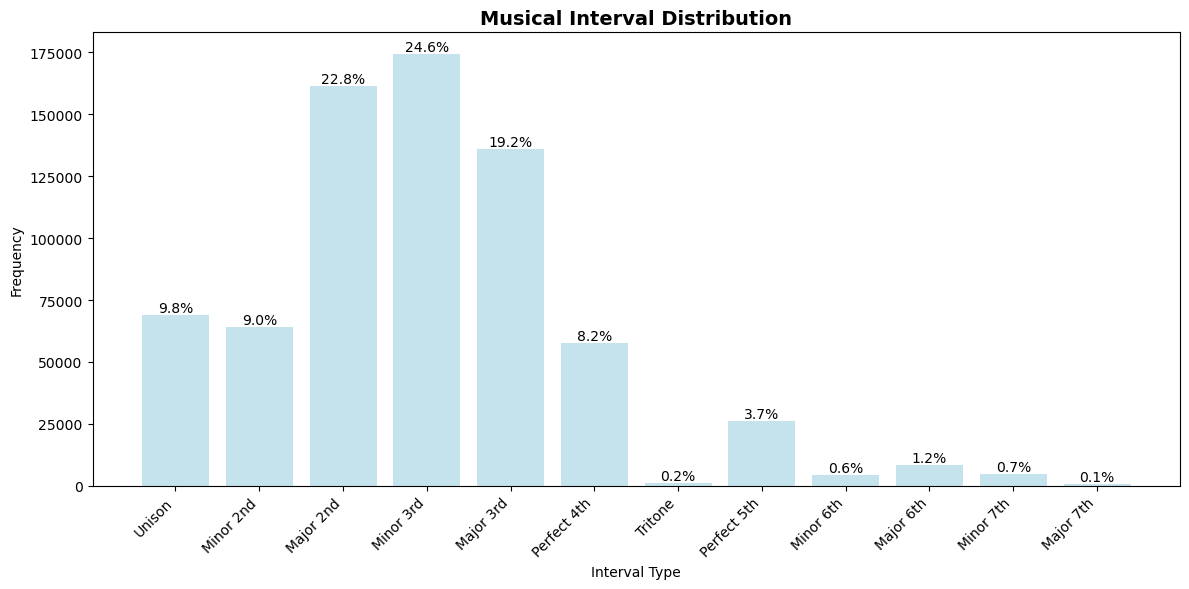


2. Analyzing Chord Progressions...

--- Chord Analysis (Window Size: 3) ---
Most common chords:
  (38, 42, 45): 36364
  (43, 47, 50): 30770
  (45, 49, 52): 21356
  (67, 69, 71): 13860
  (74, 76, 78): 13734
  (76, 78, 79): 10128
  (36, 40, 43): 9784
  (71, 72, 74): 9338
  (69, 71, 72): 9030
  (73, 74, 76): 8812

3. Analyzing Rhythmic Patterns...


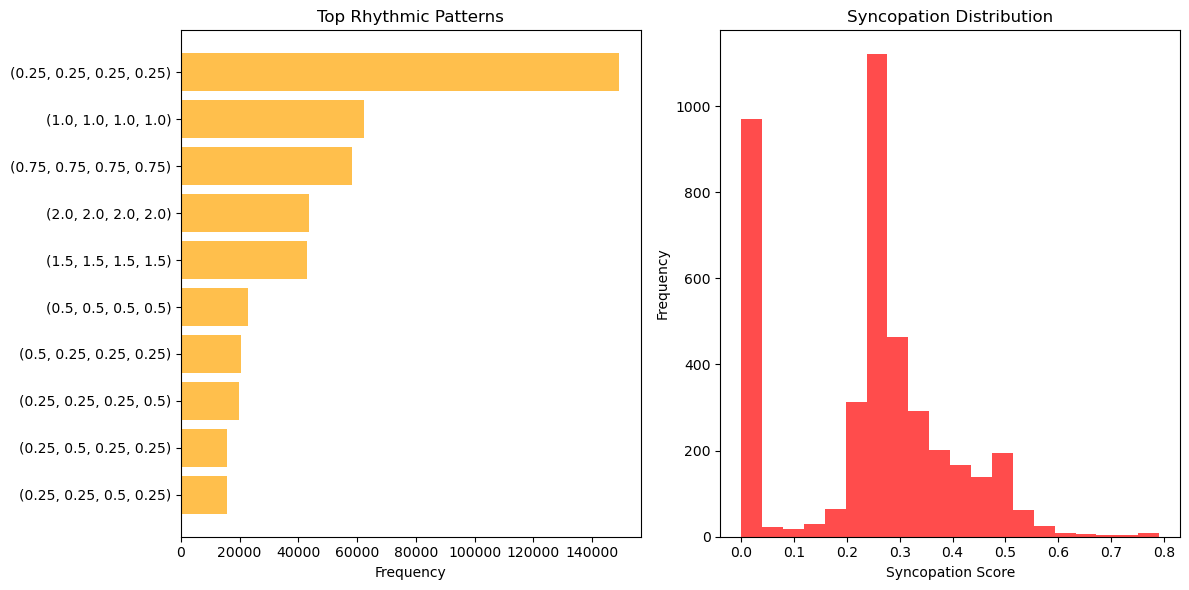


5. Analyzing Dynamics & Articulation...


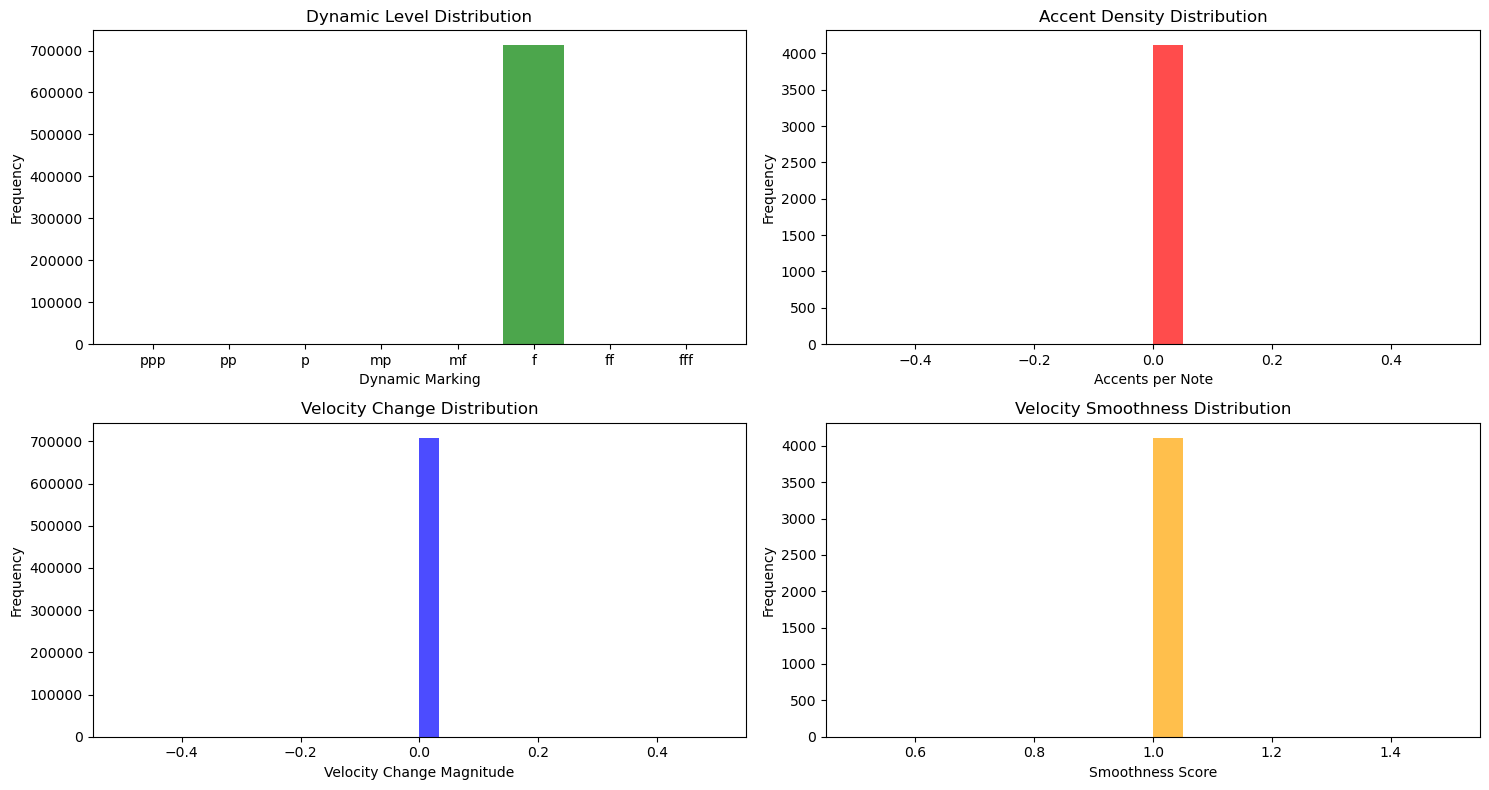


6. Analyzing Temporal Structure...


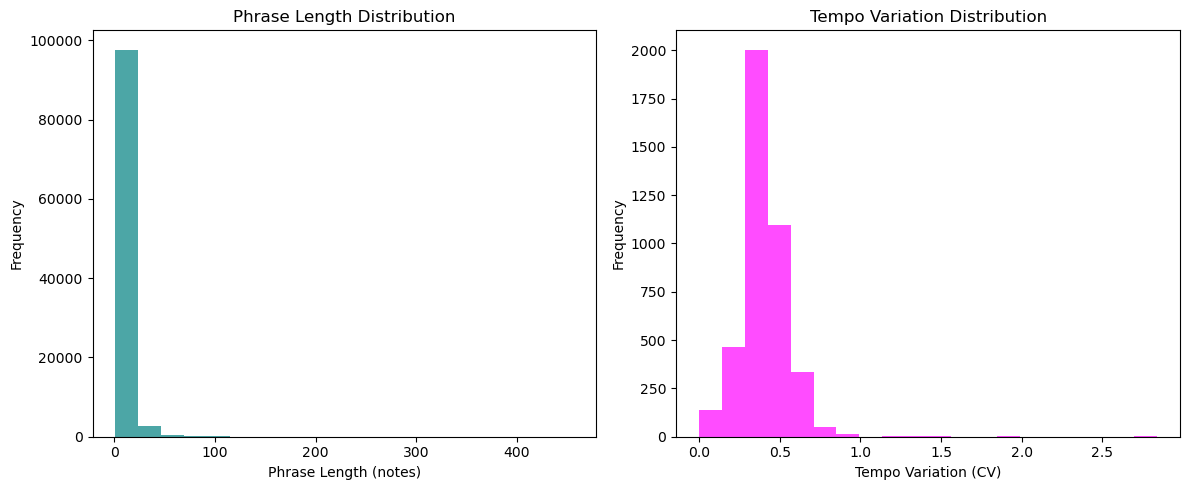


7. Analyzing Melodic Contour...

--- Melodic Contour Analysis ---
Total contour patterns: 243
Arch-like patterns: 27
Wave-like patterns: 10

Top 10 contour patterns:
  UUDUU: 91859
  DUUDU: 62156
  UDUUD: 61939
  UUUDU: 27114
  DUUUD: 24966
  UDUUU: 23510
  UUDDD: 10892
  DUUSU: 10639
  UDUUS: 10552
  UUSUU: 10508


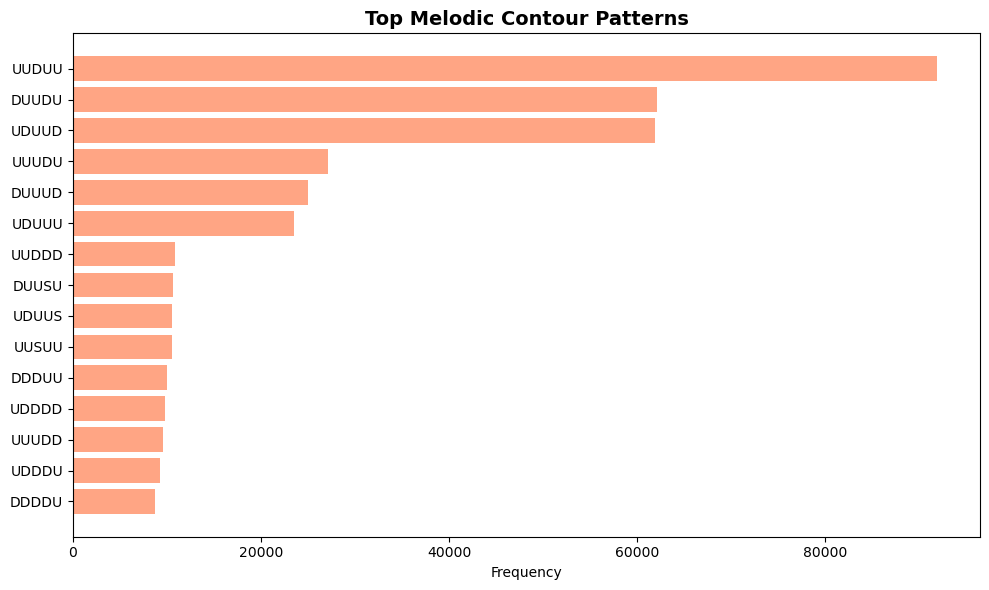


✅ Comprehensive analysis complete!
❌ EDA analysis failed: name 'keys' is not defined


'\n# Your current setup:\ndataset_dir = "MIDI"\ntoken_dir = "mid_tokens"  # wherever you\'re saving tokens\nmidi_files = list(Path(dataset_dir).rglob("*.mid"))\nprint(f"Found {len(midi_files)} MIDI files.")\ntokenizer.tokenize_midi_dataset(midi_files, token_dir)\n\n# Now run comprehensive EDA:\nresults = run_eda_from_your_data(\n    midi_dir="MIDI", \n    token_dir="mid_tokens", \n    tokenizer=tokenizer\n)\n\n# Or just from MIDI files:\nresults = run_eda_from_your_data(midi_dir="MIDI")\n\n# Or analyze tokenizer vocabulary first:\ntoken_types = analyze_token_vocabulary(tokenizer)\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats
import pandas as pd

def analyze_musical_intervals(pitch_sequences):
    """Analyze intervals between consecutive pitches"""
    intervals = []
    interval_names = {
        0: 'Unison', 1: 'Minor 2nd', 2: 'Major 2nd', 3: 'Minor 3rd', 
        4: 'Major 3rd', 5: 'Perfect 4th', 6: 'Tritone', 7: 'Perfect 5th',
        8: 'Minor 6th', 9: 'Major 6th', 10: 'Minor 7th', 11: 'Major 7th'
    }
    
    for sequence in pitch_sequences:
        for i in range(len(sequence) - 1):
            interval = abs(sequence[i+1] - sequence[i]) % 12
            intervals.append(interval)
    
    interval_counts = Counter(intervals)
    
    # Plot interval distribution
    plt.figure(figsize=(12, 6))
    intervals_list = list(range(12))
    counts = [interval_counts[i] for i in intervals_list]
    names = [interval_names[i] for i in intervals_list]
    
    bars = plt.bar(names, counts, color='lightblue', alpha=0.7)
    plt.title('Musical Interval Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Interval Type')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    
    # Add percentages
    total = sum(counts)
    for bar, count in zip(bars, counts):
        pct = (count / total) * 100
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return interval_counts

def analyze_chord_progressions(pitch_sequences, window_size=3):
    """Analyze simultaneous notes (chords) and progressions"""
    chord_types = Counter()
    progressions = Counter()
    
    for sequence in pitch_sequences:
        # Sliding window for chord analysis
        for i in range(len(sequence) - window_size + 1):
            chord = tuple(sorted(sequence[i:i+window_size]))
            chord_types[chord] += 1
            
            # Chord progressions (root movement)
            if i > 0:
                prev_chord = tuple(sorted(sequence[i-1:i+window_size-1]))
                progression = (prev_chord, chord)
                progressions[progression] += 1
    
    print(f"\n--- Chord Analysis (Window Size: {window_size}) ---")
    print(f"Most common chords:")
    for chord, count in chord_types.most_common(10):
        print(f"  {chord}: {count}")
    
    return chord_types, progressions

def analyze_rhythmic_patterns(duration_sequences):
    """Analyze rhythmic patterns and groupings"""
    rhythm_patterns = Counter()
    syncopation_score = []
    
    for sequence in duration_sequences:
        # Convert to rhythm pattern (quantized durations)
        quantized = [round(d * 4) / 4 for d in sequence]  # Quarter note quantization
        
        # Analyze 4-note rhythm patterns
        for i in range(len(quantized) - 3):
            pattern = tuple(quantized[i:i+4])
            rhythm_patterns[pattern] += 1
        
        # Calculate syncopation (off-beat emphasis)
        beat_positions = np.cumsum([0] + quantized[:-1]) % 1
        syncopation = sum(1 for pos in beat_positions if 0.25 < pos < 0.75)
        syncopation_score.append(syncopation / len(sequence))
    
    # Plot rhythmic patterns
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    top_patterns = rhythm_patterns.most_common(10)
    pattern_strs = [str(p) for p, _ in top_patterns]
    counts = [c for _, c in top_patterns]
    
    plt.barh(range(len(pattern_strs)), counts, color='orange', alpha=0.7)
    plt.yticks(range(len(pattern_strs)), pattern_strs)
    plt.title('Top Rhythmic Patterns')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    
    plt.subplot(1, 2, 2)
    plt.hist(syncopation_score, bins=20, alpha=0.7, color='red')
    plt.title('Syncopation Distribution')
    plt.xlabel('Syncopation Score')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return rhythm_patterns

def analyze_key_signatures(pitch_sequences):
    """Analyze key signatures using pitch class profiles"""
    # Major and minor key profiles (Krumhansl-Schmuckler)
    major_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    minor_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    
    key_signatures = []
    
    for sequence in pitch_sequences:
        # Calculate pitch class distribution
        pitch_classes = [p % 12 for p in sequence]
        pc_counts = [pitch_classes.count(i) for i in range(12)]
        
        # Normalize
        total = sum(pc_counts)
        if total > 0:
            pc_profile = [c / total for c in pc_counts]
            
            # Correlate with key profiles
            major_correlations = []
            minor_correlations = []
            
            for shift in range(12):
                shifted_profile = pc_profile[shift:] + pc_profile[:shift]
                major_corr = np.corrcoef(shifted_profile, major_profile)[0, 1]
                minor_corr = np.corrcoef(shifted_profile, minor_profile)[0, 1]
                major_correlations.append(major_corr)
                minor_correlations.append(minor_corr)
            
            # Find best key
            best_major = np.argmax(major_correlations)
            best_minor = np.argmax(minor_correlations)
            
            if max(major_correlations) > max(minor_correlations):
                key_signatures.append(f"{['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'][best_major]} Major")
            else:
                key_signatures.append(f"{['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'][best_minor]} Minor")
    
    # Plot key distribution
    key_counts = Counter(key_signatures)
    
    plt.figure(figsize=(12, 6))
    keys = list(key_counts.keys())
    counts = list(key_counts.values())
    
    plt.bar(keys, counts, color='purple', alpha=0.7)
    plt.title('Estimated Key Signature Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Key Signature')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return key_counts

def analyze_dynamics_and_articulation(velocity_sequences):
    """Analyze dynamics, articulation patterns, and expression"""
    dynamics = {
        'ppp': (0, 16), 'pp': (16, 32), 'p': (32, 48), 'mp': (48, 64),
        'mf': (64, 80), 'f': (80, 96), 'ff': (96, 112), 'fff': (112, 127)
    }
    
    dynamic_distribution = Counter()
    accent_patterns = []
    velocity_changes = []
    
    for sequence in velocity_sequences:
        # Classify dynamics
        for vel in sequence:
            for dynamic, (low, high) in dynamics.items():
                if low <= vel < high:
                    dynamic_distribution[dynamic] += 1
                    break
        
        # Analyze accents (sudden velocity increases)
        accents = 0
        changes = []
        for i in range(1, len(sequence)):
            change = sequence[i] - sequence[i-1]
            changes.append(abs(change))
            if change > 20:  # Accent threshold
                accents += 1
        
        accent_patterns.append(accents / len(sequence))
        velocity_changes.extend(changes)
    
    # Plot dynamics analysis
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 2, 1)
    dynamics_list = list(dynamics.keys())
    counts = [dynamic_distribution[d] for d in dynamics_list]
    plt.bar(dynamics_list, counts, color='green', alpha=0.7)
    plt.title('Dynamic Level Distribution')
    plt.xlabel('Dynamic Marking')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 2)
    plt.hist(accent_patterns, bins=20, alpha=0.7, color='red')
    plt.title('Accent Density Distribution')
    plt.xlabel('Accents per Note')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 3)
    plt.hist(velocity_changes, bins=30, alpha=0.7, color='blue')
    plt.title('Velocity Change Distribution')
    plt.xlabel('Velocity Change Magnitude')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 4)
    # Smoothness analysis
    smoothness_scores = []
    for sequence in velocity_sequences:
        if len(sequence) > 1:
            variance = np.var(sequence)
            smoothness_scores.append(1 / (1 + variance))  # Inverse relationship
    
    plt.hist(smoothness_scores, bins=20, alpha=0.7, color='orange')
    plt.title('Velocity Smoothness Distribution')
    plt.xlabel('Smoothness Score')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return dynamic_distribution

def analyze_temporal_structure(duration_sequences, pitch_sequences):
    """Analyze temporal aspects: tempo changes, phrase structure"""
    phrase_lengths = []
    tempo_variations = []
    
    for i, (durations, pitches) in enumerate(zip(duration_sequences, pitch_sequences)):
        # Phrase detection (based on longer notes or pitch jumps)
        phrase_breaks = [0]
        for j in range(1, len(durations)):
            # Phrase break criteria
            if (durations[j] > np.mean(durations) * 2 or  # Long note
                abs(pitches[j] - pitches[j-1]) > 5):      # Large pitch jump
                phrase_breaks.append(j)
        phrase_breaks.append(len(durations))
        
        # Calculate phrase lengths
        for k in range(len(phrase_breaks) - 1):
            phrase_len = phrase_breaks[k+1] - phrase_breaks[k]
            phrase_lengths.append(phrase_len)
        
        # Tempo variation (based on duration changes)
        if len(durations) > 1:
            tempo_var = np.std(durations) / np.mean(durations)
            tempo_variations.append(tempo_var)
    
    # Plot temporal analysis
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(phrase_lengths, bins=20, alpha=0.7, color='teal')
    plt.title('Phrase Length Distribution')
    plt.xlabel('Phrase Length (notes)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(tempo_variations, bins=20, alpha=0.7, color='magenta')
    plt.title('Tempo Variation Distribution')
    plt.xlabel('Tempo Variation (CV)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return phrase_lengths, tempo_variations

def analyze_melodic_contour(pitch_sequences):
    """Analyze melodic contour and direction patterns"""
    contour_patterns = Counter()
    direction_sequences = []
    
    for sequence in pitch_sequences:
        if len(sequence) < 3:
            continue
            
        # Convert to contour (up, down, same)
        contour = []
        directions = []
        
        for i in range(1, len(sequence)):
            diff = sequence[i] - sequence[i-1]
            if diff > 0:
                contour.append('U')  # Up
                directions.append(1)
            elif diff < 0:
                contour.append('D')  # Down
                directions.append(-1)
            else:
                contour.append('S')  # Same
                directions.append(0)
        
        direction_sequences.append(directions)
        
        # Analyze 5-note contour patterns
        for i in range(len(contour) - 4):
            pattern = ''.join(contour[i:i+5])
            contour_patterns[pattern] += 1
    
    # Calculate contour statistics
    arch_patterns = sum(1 for p in contour_patterns if 'UUD' in p or 'UUDD' in p)
    wave_patterns = sum(1 for p in contour_patterns if 'UDUD' in p or 'DUDU' in p)
    
    print(f"\n--- Melodic Contour Analysis ---")
    print(f"Total contour patterns: {len(contour_patterns)}")
    print(f"Arch-like patterns: {arch_patterns}")
    print(f"Wave-like patterns: {wave_patterns}")
    print(f"\nTop 10 contour patterns:")
    for pattern, count in contour_patterns.most_common(10):
        print(f"  {pattern}: {count}")
    
    # Plot contour analysis
    plt.figure(figsize=(10, 6))
    top_contours = contour_patterns.most_common(15)
    patterns = [p for p, _ in top_contours]
    counts = [c for _, c in top_contours]
    
    plt.barh(range(len(patterns)), counts, color='coral', alpha=0.7)
    plt.yticks(range(len(patterns)), patterns)
    plt.title('Top Melodic Contour Patterns', fontsize=14, fontweight='bold')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return contour_patterns

# Comprehensive analysis function
def run_comprehensive_music_eda(pitch_sequences, duration_sequences, velocity_sequences):
    """Run all additional EDA analyses"""
    print("🎵 COMPREHENSIVE MUSIC EDA ANALYSIS")
    print("="*50)
    
    print("\n1. Analyzing Musical Intervals...")
    intervals = analyze_musical_intervals(pitch_sequences)
    
    print("\n2. Analyzing Chord Progressions...")
    chords, progressions = analyze_chord_progressions(pitch_sequences)
    
    print("\n3. Analyzing Rhythmic Patterns...")
    rhythms = analyze_rhythmic_patterns(duration_sequences)
  
    
    print("\n5. Analyzing Dynamics & Articulation...")
    dynamics = analyze_dynamics_and_articulation(velocity_sequences)
    
    print("\n6. Analyzing Temporal Structure...")
    phrases, tempo_vars = analyze_temporal_structure(duration_sequences, pitch_sequences)
    
    print("\n7. Analyzing Melodic Contour...")
    contours = analyze_melodic_contour(pitch_sequences)
    
    print("\n Comprehensive analysis complete!")
    
    return {
        'intervals': intervals, 'chords': chords, 'rhythms': rhythms,
        'keys': keys, 'dynamics': dynamics, 'phrases': phrases,
        'contours': contours
    }


import json
import numpy as np
from pathlib import Path
import pretty_midi
from collections import defaultdict
import re

def extract_from_midi_files(midi_dir):
    """Extract pitch, duration, and velocity sequences directly from MIDI files"""
    # Use rglob to match your recursive search pattern
    midi_files = list(Path(midi_dir).rglob("*.mid")) + list(Path(midi_dir).rglob("*.midi"))
    
    pitch_sequences = []
    duration_sequences = []
    velocity_sequences = []
    
    print(f"Processing {len(midi_files)} MIDI files from {midi_dir}...")
    
    for i, midi_file in enumerate(midi_files):
        if i % 100 == 0:  # Progress indicator for large datasets
            print(f"  Processed {i}/{len(midi_files)} files...")
            
        try:
            midi_data = pretty_midi.PrettyMIDI(str(midi_file))
            
            for instrument in midi_data.instruments:
                if instrument.is_drum:
                    continue  # Skip drum tracks
                
                if len(instrument.notes) == 0:
                    continue
                
                # Sort notes by start time
                notes = sorted(instrument.notes, key=lambda x: x.start)
                
                pitches = [note.pitch for note in notes]
                durations = [note.end - note.start for note in notes]
                velocities = [note.velocity for note in notes]
                
                # Only add if sequence has reasonable length
                if len(pitches) > 5:
                    pitch_sequences.append(pitches)
                    duration_sequences.append(durations)
                    velocity_sequences.append(velocities)
                    
        except Exception as e:
            # Don't print every error to avoid spam with large datasets
            if i < 10:  # Only show first few errors
                print(f"Error processing {midi_file.name}: {e}")
            continue

    print(f"Extracted {len(pitch_sequences)} sequences from {len(midi_files)} MIDI files")
    return pitch_sequences, duration_sequences, velocity_sequences

def extract_from_tokenizer_outputs(token_dir, tokenizer):
    """Extract musical sequences from tokenizer outputs"""
    token_files = list(Path(token_dir).glob("*.json"))
    
    pitch_sequences = []
    duration_sequences = []
    velocity_sequences = []
    
    # Create reverse mapping
    id2token = {v: k for k, v in tokenizer.vocab.items()}
    
    print(f"Processing {len(token_files)} token files...")
    
    for file_path in token_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                token_ids = data.get("ids", [])
                
                # Handle nested lists
                if any(isinstance(i, list) for i in token_ids):
                    sequences = [seq for seq in token_ids if isinstance(seq, list)]
                else:
                    sequences = [token_ids]
                
                for sequence in sequences:
                    pitches, durations, velocities = parse_token_sequence(sequence, id2token)
                    
                    if len(pitches) > 5:  # Only keep sequences with reasonable length
                        pitch_sequences.append(pitches)
                        duration_sequences.append(durations)
                        velocity_sequences.append(velocities)
                        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    print(f"Extracted {len(pitch_sequences)} sequences from token files")
    return pitch_sequences, duration_sequences, velocity_sequences

def parse_token_sequence(token_ids, id2token):
    """Parse a token sequence to extract musical information"""
    pitches = []
    durations = []
    velocities = []
    
    current_pitch = None
    current_duration = 0.25  # Default quarter note
    current_velocity = 64    # Default velocity
    
    for token_id in token_ids:
        token_str = id2token.get(token_id, "")
        
        # Parse different token types based on common patterns
        if token_str.startswith("pitch_"):
            # Extract pitch value
            try:
                pitch_val = int(token_str.split("_")[1])
                current_pitch = pitch_val
            except:
                continue
                
        elif token_str.startswith("dur_") or token_str.startswith("duration_"):
            # Extract duration value
            try:
                dur_parts = token_str.split("_")
                if len(dur_parts) > 1:
                    # Handle different duration formats
                    dur_str = dur_parts[1]
                    if "." in dur_str:
                        current_duration = float(dur_str)
                    else:
                        # Convert from ticks or other format
                        dur_val = int(dur_str)
                        current_duration = dur_val / 480.0  # Assuming 480 ticks per beat
            except:
                continue
                
        elif token_str.startswith("vel_") or token_str.startswith("velocity_"):
            # Extract velocity value
            try:
                vel_val = int(token_str.split("_")[1])
                current_velocity = max(1, min(127, vel_val))  # Clamp to MIDI range
            except:
                continue
                
        elif token_str.startswith("note_") or token_str == "note":
            # Note event - commit current values
            if current_pitch is not None:
                pitches.append(current_pitch)
                durations.append(current_duration)
                velocities.append(current_velocity)
                
        # Handle other common token patterns
        elif token_str.startswith("bar") or token_str.startswith("beat"):
            # Timing tokens - might reset or mark positions
            continue
        elif re.match(r'^\d+$', token_str):
            # Pure number tokens - could be pitch values
            try:
                num_val = int(token_str)
                if 21 <= num_val <= 108:  # MIDI pitch range
                    current_pitch = num_val
            except:
                continue
    
    # If we have some musical data but no explicit note events,
    # try to infer from the available data
    if not pitches and current_pitch is not None:
        # Single note case
        pitches = [current_pitch]
        durations = [current_duration]
        velocities = [current_velocity]
    
    return pitches, durations, velocities

def analyze_token_vocabulary(tokenizer):
    """Analyze tokenizer vocabulary to understand token structure"""
    vocab = tokenizer.vocab
    token_types = defaultdict(list)
    
    for token, token_id in vocab.items():
        if "_" in token:
            prefix = token.split("_")[0]
            token_types[prefix].append(token)
        else:
            token_types["other"].append(token)
    
    print("Token Vocabulary Analysis:")
    print("-" * 30)
    for token_type, tokens in sorted(token_types.items()):
        print(f"{token_type}: {len(tokens)} tokens")
        if len(tokens) <= 10:
            print(f"  Examples: {tokens[:5]}")
        else:
            print(f"  Examples: {tokens[:5]}...")
    
    return token_types

def auto_detect_extraction_method(midi_dir=None, token_dir=None, tokenizer=None):
    """Automatically detect the best extraction method based on available data"""
    pitch_sequences = []
    duration_sequences = []
    velocity_sequences = []
    
    # Try MIDI files first if directory exists
    if midi_dir and Path(midi_dir).exists():
        try:
            p_seq, d_seq, v_seq = extract_from_midi_files(midi_dir)
            if len(p_seq) > 0:
                pitch_sequences.extend(p_seq)
                duration_sequences.extend(d_seq)
                velocity_sequences.extend(v_seq)
                print(f"Successfully extracted from MIDI files: {len(p_seq)} sequences")
        except Exception as e:
            print(f"MIDI extraction failed: {e}")
    
    # Try tokenizer outputs if available
    if token_dir and tokenizer and Path(token_dir).exists():
        try:
            # First analyze the vocabulary
            token_types = analyze_token_vocabulary(tokenizer)
            
            p_seq, d_seq, v_seq = extract_from_tokenizer_outputs(token_dir, tokenizer)
            if len(p_seq) > 0:
                pitch_sequences.extend(p_seq)
                duration_sequences.extend(d_seq)
                velocity_sequences.extend(v_seq)
                print(f"Successfully extracted from tokenizer outputs: {len(p_seq)} sequences")
        except Exception as e:
            print(f"Tokenizer extraction failed: {e}")
    
    if len(pitch_sequences) == 0:
        print(" No musical sequences could be extracted!")
        print("Please check your data paths and formats.")
        return None, None, None
    
    print(f"\n Total extracted sequences: {len(pitch_sequences)}")
    print(f"   Average sequence length: {np.mean([len(seq) for seq in pitch_sequences]):.1f} notes")
    print(f"   Pitch range: {min(min(seq) for seq in pitch_sequences)} - {max(max(seq) for seq in pitch_sequences)}")
    print(f"   Duration range: {min(min(seq) for seq in duration_sequences):.3f} - {max(max(seq) for seq in duration_sequences):.3f}")
    print(f"   Velocity range: {min(min(seq) for seq in velocity_sequences)} - {max(max(seq) for seq in velocity_sequences)}")
    
    return pitch_sequences, duration_sequences, velocity_sequences

# Integration with your existing EDA
def run_eda_from_your_data(midi_dir=None, token_dir=None, tokenizer=None):
    """Run comprehensive EDA directly from your MIDI files and/or tokenizer outputs"""
    print("EXTRACTING MUSICAL SEQUENCES FROM YOUR DATA")
    print("="*50)
    
    # Extract sequences
    pitch_sequences, duration_sequences, velocity_sequences = auto_detect_extraction_method(
        midi_dir=midi_dir, token_dir=token_dir, tokenizer=tokenizer
    )
    
    if pitch_sequences is None:
        return None
    
    print("\n RUNNING COMPREHENSIVE MUSIC EDA")
    print("="*50)
    
    # Import your comprehensive analysis function here
    # (You'll need to copy the run_comprehensive_music_eda function from the previous artifact)
    
    try:
        results = run_comprehensive_music_eda(pitch_sequences, duration_sequences, velocity_sequences)
        return results
    except Exception as e:
        print(f"EDA analysis failed: {e}")
        return None

results = run_eda_from_your_data(
    midi_dir="MIDI", 
    token_dir="mid_tokens", 
    tokenizer=tokenizer
)
# Usage with your exact setup:
"""
# Your current setup:
dataset_dir = "MIDI"
token_dir = "mid_tokens"  # wherever you're saving tokens
midi_files = list(Path(dataset_dir).rglob("*.mid"))
print(f"Found {len(midi_files)} MIDI files.")
tokenizer.tokenize_midi_dataset(midi_files, token_dir)

# Now run comprehensive EDA:
results = run_eda_from_your_data(
    midi_dir="MIDI", 
    token_dir="mid_tokens", 
    tokenizer=tokenizer
)

# Or just from MIDI files:
results = run_eda_from_your_data(midi_dir="MIDI")

# Or analyze tokenizer vocabulary first:
token_types = analyze_token_vocabulary(tokenizer)
"""

In [35]:
tempos = []
time_sigs = []

for path in midi_paths:
    midi = MidiFile(str(path))
    tempos += [t.tempo for t in midi.tempo_changes]
    time_sigs += [(ts.numerator, ts.denominator) for ts in midi.time_signature_changes]

print("Top Tempos:", Counter(tempos).most_common(1))
print("Time Signature Counts:", Counter(time_sigs))


Top Tempos: [(120, 3089)]
Time Signature Counts: Counter({(4, 4): 2228, (6, 8): 1544, (3, 4): 256, (2, 4): 184, (9, 8): 68, (6, 4): 36, (2, 2): 26, (5, 4): 24, (3, 2): 12})


In [37]:
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

Tokenizer vocab size: 282


In [39]:
id2token = {v: k for k, v in tokenizer.vocab.items()}
id2token

{0: 'PAD_None',
 1: 'BOS_None',
 2: 'EOS_None',
 3: 'MASK_None',
 4: 'Bar_None',
 5: 'Pitch_21',
 6: 'Pitch_22',
 7: 'Pitch_23',
 8: 'Pitch_24',
 9: 'Pitch_25',
 10: 'Pitch_26',
 11: 'Pitch_27',
 12: 'Pitch_28',
 13: 'Pitch_29',
 14: 'Pitch_30',
 15: 'Pitch_31',
 16: 'Pitch_32',
 17: 'Pitch_33',
 18: 'Pitch_34',
 19: 'Pitch_35',
 20: 'Pitch_36',
 21: 'Pitch_37',
 22: 'Pitch_38',
 23: 'Pitch_39',
 24: 'Pitch_40',
 25: 'Pitch_41',
 26: 'Pitch_42',
 27: 'Pitch_43',
 28: 'Pitch_44',
 29: 'Pitch_45',
 30: 'Pitch_46',
 31: 'Pitch_47',
 32: 'Pitch_48',
 33: 'Pitch_49',
 34: 'Pitch_50',
 35: 'Pitch_51',
 36: 'Pitch_52',
 37: 'Pitch_53',
 38: 'Pitch_54',
 39: 'Pitch_55',
 40: 'Pitch_56',
 41: 'Pitch_57',
 42: 'Pitch_58',
 43: 'Pitch_59',
 44: 'Pitch_60',
 45: 'Pitch_61',
 46: 'Pitch_62',
 47: 'Pitch_63',
 48: 'Pitch_64',
 49: 'Pitch_65',
 50: 'Pitch_66',
 51: 'Pitch_67',
 52: 'Pitch_68',
 53: 'Pitch_69',
 54: 'Pitch_70',
 55: 'Pitch_71',
 56: 'Pitch_72',
 57: 'Pitch_73',
 58: 'Pitch_74',
 59: '

# Task 2 Baseline: Hidden Markov Model

## Download and import Dependencies

In [3]:
!pip install pretty_midi music21 hmmlearn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import math
from music21 import converter, note, chord
from hmmlearn import hmm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import pretty_midi
from music21 import stream, note, chord, key, meter, tempo, pitch, interval, instrument, converter

import requests
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, melody_dir, chord_dir, file_list, max_seq_len=512, time_resolution=0.125):
        self.melody_dir = melody_dir
        self.chord_dir = chord_dir
        self.file_list = file_list
        self.max_seq_len = max_seq_len
        self.time_resolution = time_resolution  

    def __len__(self):
        return len(self.file_list)

    def _quantize_melody(self, midi: pretty_midi.PrettyMIDI):
        melody_seq = [0] * self.max_seq_len
        notes = []
        for instrument in midi.instruments:
            if not instrument.is_drum:
                notes += instrument.notes
    
        notes.sort(key=lambda n: n.start)
    
        for note in notes:
            start_idx = int(note.start / self.time_resolution)
            end_idx = int(note.end / self.time_resolution)
    
            for idx in range(start_idx, end_idx + 1):
                if 0 <= idx < self.max_seq_len and melody_seq[idx] == 0:
                    melody_seq[idx] = note.pitch  
    
        return melody_seq

    def _quantize_chords(self, midi: pretty_midi.PrettyMIDI):
        chord_seq = [[0, 0, 0] for _ in range(self.max_seq_len)]
        notes = []
        for instrument in midi.instruments:
            if not instrument.is_drum:
                notes += instrument.notes
    
        note_bins = [[] for _ in range(self.max_seq_len)]
    
        for note in notes:
            start_idx = int(note.start / self.time_resolution)
            end_idx = int(note.end / self.time_resolution)
    
            for idx in range(start_idx, end_idx + 1):
                if 0 <= idx < self.max_seq_len:
                    note_bins[idx].append(note.pitch)
    
        for i in range(self.max_seq_len):
            chord = sorted(set(note_bins[i]))[:3]
            if len(chord) < 3:
                chord += [0] * (3 - len(chord))
            chord_seq[i] = chord
    
        return chord_seq

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        melody_path = os.path.join(self.melody_dir, filename)
        chord_path = os.path.join(self.chord_dir, filename)

        melody_midi = pretty_midi.PrettyMIDI(melody_path)
        chord_midi = pretty_midi.PrettyMIDI(chord_path)

        melody_seq = self._quantize_melody(melody_midi)
        chord_seq = self._quantize_chords(chord_midi)

        melody_tensor = torch.tensor(melody_seq, dtype=torch.long)             
        chord_tensor = torch.tensor(chord_seq, dtype=torch.long)               

        return melody_tensor, chord_tensor, filename

In [ ]:
melody_dir = "/kaggle/input/nottingham/MIDI/melody"
chord_dir = "/kaggle/input/nottingham/MIDI/chords"
file_list = os.listdir(chord_dir)

dataset = MusicDataset(melody_dir, chord_dir, file_list)
all_data = []

note_to_int = {}
chord_to_int = {}
note_idx = 1  
chord_idx = 1

for i in range(len(dataset)):
    data = dataset[i]
    if data is None: continue
    melody_seq, chord_seq, fname = data
    melody_seq = melody_seq.tolist()
    chord_seq = chord_seq.tolist()

    m_seq = []
    c_seq = []

    for m, c in zip(melody_seq, chord_seq):
        if m not in note_to_int:
            note_to_int[m] = note_idx
            note_idx += 1
        if tuple(c) not in chord_to_int:
            chord_to_int[tuple(c)] = chord_idx
            chord_idx += 1
        m_seq.append(note_to_int[m])
        c_seq.append(chord_to_int[tuple(c)])

    all_data.append((m_seq, c_seq, fname))

print(f"Vocab size - Notes: {len(note_to_int)}, Chords: {len(chord_to_int)}")
print(f"Loaded {len(all_data)} samples with filenames.")

Vocab size - Notes: 34, Chords: 85
Loaded 1021 samples with filenames.


## Model Training

In [7]:
train_data, test_data = train_test_split(all_data, test_size=0.05, random_state=42)

In [8]:
X_train_seqs = [np.array(melody).reshape(-1, 1) for melody, _, _ in train_data]
y_train_seqs = [np.array(chords) for _, chords, _ in train_data]

def flatten(seqs):
    return np.concatenate(seqs), [len(s) for s in seqs]

X_flat, X_lens = flatten(X_train_seqs)
y_flat = np.concatenate(y_train_seqs)

n_states = len(chord_to_int)
model = hmm.MultinomialHMM(n_components=n_states, n_iter=100)
model.fit(X_flat, lengths=X_lens)

print("HMM training complete.")

HMM training complete.


## Music Generation

In [ ]:
def write_midi_from_sequence(melody_seq, chord_seq, filename_prefix, time_step=0.125):
    melody_instr = pretty_midi.Instrument(program=0, name="Melody")

    t = 0
    while t < len(melody_seq):
        note_num = melody_seq[t]
        if note_num != 0:
            start = t * time_step
            duration = time_step
            t_next = t + 1
            while t_next < len(melody_seq) and melody_seq[t_next] == note_num:
                duration += time_step
                t_next += 1
            end = start + duration
            note = pretty_midi.Note(velocity=100, pitch=int(note_num), start=start, end=end)
            melody_instr.notes.append(note)
            t = t_next
        else:
            t += 1

    chord_instr = pretty_midi.Instrument(program=0, name="Chords")

    prev_chord = None
    chord_start = 0
    
    for t, chord in enumerate(chord_seq):
        if prev_chord is None or not np.array_equal(chord, prev_chord):
            if prev_chord is not None:
                start = chord_start * time_step
                end = t * time_step
                for note_num in prev_chord:
                    if note_num != 0:
                        note = pretty_midi.Note(velocity=80, pitch=int(note_num), start=start, end=end)
                        chord_instr.notes.append(note)
            prev_chord = chord
            chord_start = t
    
    if prev_chord is not None:
        start = chord_start * time_step
        end = len(chord_seq) * time_step
        for note_num in prev_chord:
            if note_num != 0:
                note = pretty_midi.Note(velocity=80, pitch=int(note_num), start=start, end=end)
                chord_instr.notes.append(note)

    pm = pretty_midi.PrettyMIDI()
    pm.instruments.append(melody_instr)
    pm.instruments.append(chord_instr)

    os.makedirs("outputs", exist_ok=True)
    pm.write(f"outputs/{filename_prefix}")

In [ ]:
def run_hmm_inference_and_save(model, test_data, output_dir="outputs3"):

    int_to_chord = {v: k for k, v in chord_to_int.items()}

    for melody_seq, chord_seq, filename in test_data:
        melody_np = np.array(melody_seq).reshape(-1, 1)
        pred_labels = model.predict(melody_np)
        pred_chords = [int_to_chord.get(label, [0, 0, 0]) for label in pred_labels]

        if isinstance(chord_seq[0], int):
            true_chords = [int_to_chord.get(label, [0, 0, 0]) for label in chord_seq]
        else:
            true_chords = chord_seq

        base_name = os.path.splitext(filename)[0]

        write_midi_from_sequence(
            melody_seq,
            true_chords,
            filename_prefix = "original_"+base_name +".mid"
        )

        write_midi_from_sequence(
            melody_seq,
            pred_chords,
            filename_prefix = "sampled_"+base_name+".mid"
        )
    print(f"Saved original and predicted harmonized files")

In [29]:
run_hmm_inference_and_save(model, test_data)

Saved original and predicted harmonized files


In [30]:
!zip outputs2.zip /kaggle/working/outputs/*

  adding: kaggle/working/outputs/original_ashover14.mid (deflated 83%)
  adding: kaggle/working/outputs/original_ashover31.mid (deflated 77%)
  adding: kaggle/working/outputs/original_ashover7.mid (deflated 73%)
  adding: kaggle/working/outputs/original_hpps12.mid (deflated 78%)
  adding: kaggle/working/outputs/original_hpps1.mid (deflated 79%)
  adding: kaggle/working/outputs/original_jigs104.mid (deflated 82%)
  adding: kaggle/working/outputs/original_jigs109.mid (deflated 85%)
  adding: kaggle/working/outputs/original_jigs141.mid (deflated 80%)
  adding: kaggle/working/outputs/original_jigs160.mid (deflated 85%)
  adding: kaggle/working/outputs/original_jigs174.mid (deflated 77%)
  adding: kaggle/working/outputs/original_jigs186.mid (deflated 80%)
  adding: kaggle/working/outputs/original_jigs195.mid (deflated 80%)
  adding: kaggle/working/outputs/original_jigs19.mid (deflated 83%)
  adding: kaggle/working/outputs/original_jigs203.mid (deflated 85%)
  adding: kaggle/working/outputs/

## Music Evaluation

In [31]:
def calculate_harmonization_metrics(melody_instr, chord_instr, time_step=0.125):
    def extract_notes(instr):
        return [(round(note.start, 3), note.pitch) for note in instr.notes if note.pitch > 0]

    def get_notes_at_time(notes, t):
        return [p for (start, p) in notes if abs(start - t) < 1e-3]

    melody_notes = extract_notes(melody_instr)
    chord_notes = extract_notes(chord_instr)

    max_time = max(
        melody_instr.notes[-1].end if melody_instr.notes else 0,
        chord_instr.notes[-1].end if chord_instr.notes else 0
    )
    all_times = [round(i * time_step, 3) for i in range(int(max_time / time_step) + 1)]

    consonant_intervals = {0, 3, 4, 5, 7, 8, 9, 12}
    consonant_count = 0
    total_count = 0

    prev_chord = None
    voice_leading_movements = []
    key_detector_stream = stream.Stream()
    chord_change_times = []

    for t in all_times:
        melody_at_t = get_notes_at_time(melody_notes, t)
        chord_at_t = get_notes_at_time(chord_notes, t)

        for m in melody_at_t:
            for c in chord_at_t:
                interval = abs(m - c) % 12
                if interval in consonant_intervals:
                    consonant_count += 1
                total_count += 1

        if prev_chord is not None and len(chord_at_t) == len(prev_chord):
            movements = [abs(p - q) for p, q in zip(prev_chord, chord_at_t)]
            voice_leading_movements.append(np.mean(movements))

        if chord_at_t:
            if prev_chord != chord_at_t:
                chord_change_times.append(t)
                prev_chord = chord_at_t
                try:
                    c = chord.Chord(chord_at_t)
                    key_detector_stream.append(c)
                except:
                    pass

    consonance_ratio = consonant_count / total_count if total_count > 0 else 0
    voice_leading = np.mean(voice_leading_movements) if voice_leading_movements else 0

    if len(chord_change_times) > 1:
        intervals = np.diff(chord_change_times)
        rhythm_std = np.std(intervals)
        rhythm_stability = 1 / (1 + rhythm_std)
    else:
        rhythm_stability = 1.0

    try:
        estimated_key = key_detector_stream.analyze('key')
        scale_pitches = set((p.midi % 12) for p in estimated_key.getPitches())
        all_chord_pitches = set(p % 12 for _, p in chord_notes)
        out_of_key_notes = [p for p in all_chord_pitches if p not in scale_pitches]
        key_consistency = 1 - (len(out_of_key_notes) / len(all_chord_pitches)) if all_chord_pitches else 1.0
    except:
        key_consistency = 0.0

    return {
        "consonance_ratio": round(consonance_ratio, 4),
        "voice_leading_smoothness": round(1 / (1 + voice_leading), 4),
        "harmonic_rhythm_stability": round(rhythm_stability, 4),
        "key_consistency": round(key_consistency, 4),
        "num_chord_changes": len(chord_change_times),
    }

In [19]:
def process_midi_folder(folder_path, time_step=0.125):
    from collections import defaultdict

    metric_sums = defaultdict(float)
    file_count = 0

    for filename in os.listdir(folder_path):
        if not filename.endswith(".mid"):
            continue

        filepath = os.path.join(folder_path, filename)
        try:
            pm = pretty_midi.PrettyMIDI(filepath)
            if len(pm.instruments) < 2:
                print(f"Skipping {filename}: not enough instruments")
                continue

            melody_instr = pm.instruments[0]
            chord_instr = pm.instruments[1]

            metrics = calculate_harmonization_metrics(melody_instr, chord_instr, time_step=time_step)

            for k, v in metrics.items():
                metric_sums[k] += v

            file_count += 1

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    if file_count == 0:
        return None

    avg_metrics = {k: round(v / file_count, 4) for k, v in metric_sums.items()}
    return avg_metrics

In [32]:
folder_path = "/kaggle/working/outputs"
avg_metrics = process_midi_folder(folder_path)

if avg_metrics:
    print("Average Harmonization Metrics:")
    for k, v in avg_metrics.items():
        print(f"{k}: {v}")
else:
    print("No valid MIDI files found.")

Average Harmonization Metrics:
consonance_ratio: 0.534
voice_leading_smoothness: 0.1898
harmonic_rhythm_stability: 0.7346
key_consistency: 0.7376
num_chord_changes: 280.5769


# Task 2 Improved: Music Transformer

## Download and import Dependencies

In [3]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 74.2 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=d6f98227febb054a65b5f4dcff4bef422a37c90794fdd1619cf00c5e4e265567
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import math

# Deep learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# MIDI processing
import pretty_midi
from music21 import stream, note, chord, key, meter, tempo, pitch, interval

# Download and setup
import requests
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [5]:
class MusicDataset(Dataset):
    def __init__(self, melody_dir, chord_dir, file_list, max_seq_len=512, time_resolution=0.125):
        self.melody_dir = melody_dir
        self.chord_dir = chord_dir
        self.file_list = file_list
        self.max_seq_len = max_seq_len
        self.time_resolution = time_resolution  # in seconds

    def __len__(self):
        return len(self.file_list)

    def _quantize_melody(self, midi: pretty_midi.PrettyMIDI):
        melody_seq = [0] * self.max_seq_len
        notes = []
        for instrument in midi.instruments:
            if not instrument.is_drum:
                notes += instrument.notes
    
        # Optional: sort by note start time to prioritize earlier notes
        notes.sort(key=lambda n: n.start)
    
        for note in notes:
            start_idx = int(note.start / self.time_resolution)
            end_idx = int(note.end / self.time_resolution)
    
            for idx in range(start_idx, end_idx + 1):
                if 0 <= idx < self.max_seq_len and melody_seq[idx] == 0:
                    melody_seq[idx] = note.pitch  # Assign if empty
    
        return melody_seq

    def _quantize_chords(self, midi: pretty_midi.PrettyMIDI):
        chord_seq = [[0, 0, 0] for _ in range(self.max_seq_len)]
        notes = []
        for instrument in midi.instruments:
            if not instrument.is_drum:
                notes += instrument.notes
    
        # Create a note bin for each timestep
        note_bins = [[] for _ in range(self.max_seq_len)]
    
        for note in notes:
            start_idx = int(note.start / self.time_resolution)
            end_idx = int(note.end / self.time_resolution)
    
            for idx in range(start_idx, end_idx + 1):
                if 0 <= idx < self.max_seq_len:
                    note_bins[idx].append(note.pitch)
    
        # Select top-3 notes (by pitch) for each timestep
        for i in range(self.max_seq_len):
            chord = sorted(set(note_bins[i]))[:3]
            if len(chord) < 3:
                chord += [0] * (3 - len(chord))
            chord_seq[i] = chord
    
        return chord_seq

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        melody_path = os.path.join(self.melody_dir, filename)
        chord_path = os.path.join(self.chord_dir, filename)

        melody_midi = pretty_midi.PrettyMIDI(melody_path)
        chord_midi = pretty_midi.PrettyMIDI(chord_path)

        melody_seq = self._quantize_melody(melody_midi)
        chord_seq = self._quantize_chords(chord_midi)

        melody_tensor = torch.tensor(melody_seq, dtype=torch.long)              # shape: [T]
        chord_tensor = torch.tensor(chord_seq, dtype=torch.long)                # shape: [T, 3]

        return melody_tensor, chord_tensor, filename

In [6]:
melody_dir = "/kaggle/input/nottingham-music/MIDI/melody"
chord_dir = "/kaggle/input/nottingham-music/MIDI/chords"

In [7]:
all_files = sorted(os.listdir(melody_dir))
all_files = [f for f in all_files if f.endswith('.mid') and os.path.exists(os.path.join(chord_dir, f))]
seed = 42
test_ratio = 0.1
val_ratio = 0.1
random.seed(seed)
random.shuffle(all_files)


# Train/Val/Test split
train_files, test_files = train_test_split(all_files, test_size=test_ratio, random_state=seed)
train_files, val_files = train_test_split(train_files, test_size=val_ratio / (1 - test_ratio), random_state=seed)

In [8]:
max_seq_len = 512
train_dataset = MusicDataset(melody_dir, chord_dir, train_files)
val_dataset   = MusicDataset(melody_dir, chord_dir, val_files)
test_dataset  = MusicDataset(melody_dir, chord_dir, test_files)

In [9]:
train_dataset

In [10]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


## Model

In [11]:
class MusicTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nhead=4, num_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(emb_dim, 3 * vocab_size)  # For 3 chord notes
        self.vocab_size = vocab_size

    def forward(self, melody):  # melody: [B, T]
        x = self.embedding(melody)        # [B, T, D]
        x = self.transformer(x)           # [B, T, D]
        x = self.fc(x)                    # [B, T, 3 * vocab_size]
        x = x.view(x.size(0), x.size(1), 3, self.vocab_size)  # [B, T, 3, vocab_size]
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
vocab_size = 128
model = MusicTransformer(
    vocab_size=vocab_size,
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,438,016


## Model Training

In [14]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for melodies, chords, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            melodies, chords = melodies.to(device), chords.to(device)

            outputs = model(melodies)
            # print(outputs.shape)
            # print(melodies.shape)
            # print(chords.shape)
            loss = sum(
                criterion(outputs[:, :, i, :].reshape(-1, 128), chords[:, :, i].reshape(-1))
                for i in range(3)
            ) / 3

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}] Train Loss: {total_loss / len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for melodies, chords, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                melodies, chords = melodies.to(device), chords.to(device)
                outputs = model(melodies)
                loss = sum(
                    criterion(outputs[:, :, i, :].reshape(-1, 128), chords[:, :, i].reshape(-1))
                    for i in range(3)
                ) / 3
                val_loss += loss.item()

        print(f"           Val Loss: {val_loss / len(val_loader):.4f}")

In [15]:
train_model(model, train_loader, val_loader, num_epochs=20,lr=1e-4)

Epoch 1/20 - Training: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


[Epoch 1] Train Loss: 3.6272


Epoch 1/20 - Validation: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


           Val Loss: 2.9094


Epoch 2/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]


[Epoch 2] Train Loss: 2.7111


Epoch 2/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


           Val Loss: 2.3874


Epoch 3/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.20it/s]


[Epoch 3] Train Loss: 2.2941


Epoch 3/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


           Val Loss: 2.0735


Epoch 4/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.28it/s]


[Epoch 4] Train Loss: 2.0150


Epoch 4/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


           Val Loss: 1.8320


Epoch 5/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]


[Epoch 5] Train Loss: 1.8070


Epoch 5/20 - Validation: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


           Val Loss: 1.6607


Epoch 6/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.23it/s]


[Epoch 6] Train Loss: 1.6563


Epoch 6/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


           Val Loss: 1.5340


Epoch 7/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]


[Epoch 7] Train Loss: 1.5481


Epoch 7/20 - Validation: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


           Val Loss: 1.4517


Epoch 8/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.25it/s]


[Epoch 8] Train Loss: 1.4683


Epoch 8/20 - Validation: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


           Val Loss: 1.3780


Epoch 9/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]


[Epoch 9] Train Loss: 1.4074


Epoch 9/20 - Validation: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


           Val Loss: 1.3292


Epoch 10/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]


[Epoch 10] Train Loss: 1.3578


Epoch 10/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


           Val Loss: 1.2870


Epoch 11/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]


[Epoch 11] Train Loss: 1.3226


Epoch 11/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


           Val Loss: 1.2692


Epoch 12/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.27it/s]


[Epoch 12] Train Loss: 1.2960


Epoch 12/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


           Val Loss: 1.2373


Epoch 13/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]


[Epoch 13] Train Loss: 1.2701


Epoch 13/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


           Val Loss: 1.2179


Epoch 14/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.28it/s]


[Epoch 14] Train Loss: 1.2498


Epoch 14/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


           Val Loss: 1.2017


Epoch 15/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]


[Epoch 15] Train Loss: 1.2417


Epoch 15/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


           Val Loss: 1.1886


Epoch 16/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]


[Epoch 16] Train Loss: 1.2252


Epoch 16/20 - Validation: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


           Val Loss: 1.1774


Epoch 17/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.22it/s]


[Epoch 17] Train Loss: 1.2105


Epoch 17/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


           Val Loss: 1.1684


Epoch 18/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.23it/s]


[Epoch 18] Train Loss: 1.2018


Epoch 18/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


           Val Loss: 1.1598


Epoch 19/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.17it/s]


[Epoch 19] Train Loss: 1.1925


Epoch 19/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


           Val Loss: 1.1535


Epoch 20/20 - Training: 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]


[Epoch 20] Train Loss: 1.1785


Epoch 20/20 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

           Val Loss: 1.1474


## Music Generation

In [16]:
def write_midi_from_sequence(melody_seq, chord_seq, filename_prefix, time_step=0.125):
    """
    melody_seq: [T] (integers)
    chord_seq: [T, 3] (integers)
    """
    melody_instr = pretty_midi.Instrument(program=0, name="Melody")

    t = 0
    while t < len(melody_seq):
        note_num = melody_seq[t]
        if note_num != 0:
            start = t * time_step
            duration = time_step
            # Extend duration as long as the same note is repeated
            t_next = t + 1
            while t_next < len(melody_seq) and melody_seq[t_next] == note_num:
                duration += time_step
                t_next += 1
            end = start + duration
            note = pretty_midi.Note(velocity=100, pitch=int(note_num), start=start, end=end)
            melody_instr.notes.append(note)
            t = t_next
        else:
            t += 1

    chord_instr = pretty_midi.Instrument(program=0, name="Chords")

    prev_chord = None
    chord_start = 0
    
    for t, chord in enumerate(chord_seq):
        if prev_chord is None or not np.array_equal(chord, prev_chord):
            if prev_chord is not None:
                # Write the previous chord
                start = chord_start * time_step
                end = t * time_step
                for note_num in prev_chord:
                    if note_num != 0:
                        note = pretty_midi.Note(velocity=80, pitch=int(note_num), start=start, end=end)
                        chord_instr.notes.append(note)
            prev_chord = chord
            chord_start = t
    
    # Write final chord
    if prev_chord is not None:
        start = chord_start * time_step
        end = len(chord_seq) * time_step
        for note_num in prev_chord:
            if note_num != 0:
                note = pretty_midi.Note(velocity=80, pitch=int(note_num), start=start, end=end)
                chord_instr.notes.append(note)

    pm = pretty_midi.PrettyMIDI()
    pm.instruments.append(melody_instr)
    pm.instruments.append(chord_instr)

    os.makedirs("outputs", exist_ok=True)
    pm.write(f"outputs/{filename_prefix}")

In [17]:
def run_inference_and_save(model, test_dataset):
    model.eval()
    with torch.no_grad():
        for idx in range(len(test_dataset)):
            melody, harmony, filename = test_dataset[idx]  # (T,), (T,)
            melody = melody.unsqueeze(0).to(device)     # [1, T]
            harmony = harmony.unsqueeze(0).to(device)   # [1, T, 3]

            outputs = model(melody)                     # [1, T, 3, vocab_size]
            preds = outputs.argmax(dim=-1)              # [1, T, 3]
            melody_seq = melody.squeeze(0).cpu().numpy()        # [T]
            chord_seq = preds.squeeze(0).cpu().numpy()          # [T, 3]
            harmony_seq = harmony.squeeze(0).cpu().numpy()          # [T, 3]

            
            write_midi_from_sequence(
                melody_seq,
                chord_seq,
                filename_prefix=f"predicted_{filename}",
            )
            write_midi_from_sequence(
                melody_seq,
                harmony_seq,
                filename_prefix=f"original_{filename}"
            )

In [18]:
run_inference_and_save(model, test_dataset)

In [19]:
torch.save({
    'model_state_dict': model.state_dict(),
}, 'best_harmonization_music_transformer.pth')

## Music Evaluation

In [21]:
def calculate_harmonization_metrics(melody_instr, chord_instr, time_step=0.125):
    def extract_notes(instr):
        return [(round(note.start, 3), note.pitch) for note in instr.notes if note.pitch > 0]

    def get_notes_at_time(notes, t):
        return [p for (start, p) in notes if abs(start - t) < 1e-3]

    melody_notes = extract_notes(melody_instr)
    chord_notes = extract_notes(chord_instr)

    max_time = max(
        melody_instr.notes[-1].end if melody_instr.notes else 0,
        chord_instr.notes[-1].end if chord_instr.notes else 0
    )
    all_times = [round(i * time_step, 3) for i in range(int(max_time / time_step) + 1)]

    consonant_intervals = {0, 3, 4, 5, 7, 8, 9, 12}
    consonant_count = 0
    total_count = 0

    prev_chord = None
    voice_leading_movements = []
    key_detector_stream = stream.Stream()
    chord_change_times = []

    for t in all_times:
        melody_at_t = get_notes_at_time(melody_notes, t)
        chord_at_t = get_notes_at_time(chord_notes, t)

        for m in melody_at_t:
            for c in chord_at_t:
                interval = abs(m - c) % 12
                if interval in consonant_intervals:
                    consonant_count += 1
                total_count += 1

        if prev_chord is not None and len(chord_at_t) == len(prev_chord):
            movements = [abs(p - q) for p, q in zip(prev_chord, chord_at_t)]
            voice_leading_movements.append(np.mean(movements))

        if chord_at_t:
            if prev_chord != chord_at_t:
                chord_change_times.append(t)
                prev_chord = chord_at_t
                try:
                    c = chord.Chord(chord_at_t)
                    key_detector_stream.append(c)
                except:
                    pass

    consonance_ratio = consonant_count / total_count if total_count > 0 else 0
    voice_leading = np.mean(voice_leading_movements) if voice_leading_movements else 0

    if len(chord_change_times) > 1:
        intervals = np.diff(chord_change_times)
        rhythm_std = np.std(intervals)
        rhythm_stability = 1 / (1 + rhythm_std)
    else:
        rhythm_stability = 1.0

    try:
        estimated_key = key_detector_stream.analyze('key')
        scale_pitches = set((p.midi % 12) for p in estimated_key.getPitches())
        all_chord_pitches = set(p % 12 for _, p in chord_notes)
        out_of_key_notes = [p for p in all_chord_pitches if p not in scale_pitches]
        key_consistency = 1 - (len(out_of_key_notes) / len(all_chord_pitches)) if all_chord_pitches else 1.0
    except:
        key_consistency = 0.0

    return {
        "consonance_ratio": round(consonance_ratio, 4),
        "voice_leading_smoothness": round(1 / (1 + voice_leading), 4),
        "harmonic_rhythm_stability": round(rhythm_stability, 4),
        "key_consistency": round(key_consistency, 4),
        "num_chord_changes": len(chord_change_times),
    }

In [22]:
def process_midi_folder(folder_path, time_step=0.125):
    from collections import defaultdict

    metric_sums = defaultdict(float)
    file_count = 0

    for filename in os.listdir(folder_path):
        if not filename.endswith(".mid"):
            continue

        filepath = os.path.join(folder_path, filename)
        try:
            pm = pretty_midi.PrettyMIDI(filepath)
            if len(pm.instruments) < 2:
                print(f"Skipping {filename}: not enough instruments")
                continue

            melody_instr = pm.instruments[0]
            chord_instr = pm.instruments[1]

            metrics = calculate_harmonization_metrics(melody_instr, chord_instr, time_step=time_step)

            for k, v in metrics.items():
                metric_sums[k] += v

            file_count += 1

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    if file_count == 0:
        return None

    avg_metrics = {k: round(v / file_count, 4) for k, v in metric_sums.items()}
    return avg_metrics

In [23]:
folder_path = "/kaggle/working/outputs"
avg_metrics = process_midi_folder(folder_path)

if avg_metrics:
    print("Average Harmonization Metrics:")
    for k, v in avg_metrics.items():
        print(f"{k}: {v}")
else:
    print("No valid MIDI files found.")

Average Harmonization Metrics:
consonance_ratio: 0.9292
voice_leading_smoothness: 0.189
harmonic_rhythm_stability: 0.5788
key_consistency: 0.9232
num_chord_changes: 74.8155
